# - TODO LIST
- Write better RBR Legato correction
- Test out Robert Todd's linear method
- Variance plots?
- Reread Todd
- SNR QC
- STD in Up metric
- Is shear bias the same in up and down?
- Surface drift validation seems offset in time! look at deployment 2

# I. Settings and initialisation

## 1.1. Settings

In [1]:
options = {
    'correctRBRLag' : False, # Perform Garau lag correction (TODO, pretty crappy)
    'correctADCPHeading' : True,
    'ADCP_discardFirstBin' : True, # First bin often very affected by glider, good to discard, in future we should extend blanking distance
    'ADCP_correlationThreshold': 60,
    'ADCP_amplitudeThreshold' : 75,
    'ADCP_velocityThreshold' : 0.6,
    'correctXshear' : False,
    'correctYshear' : False,
    'correctZshear' : False,
    'correctZZshear' : False,
    }
# reprocessRawGliderData = False

# correctOxygenLag = False


## 1.2. Paths

In [2]:
### Bornholm
# adcp_path = 'D:/Storage/VOTO_ADCP/Bornholm/sea063_M22.ad2cp.00000*.nc'
# filename = 'D:/Storage/Dropbox/Jupyter/Data/Bornholm_SEA063_M22.pqt'
# top_mounted = True

### Skagerak
# adcp_path = 'D:/Storage/VOTO_ADCP/Skag/sea045_M44.ad2cp.00000*.nc'
# filename = 'D:/Storage/Dropbox/Jupyter/Data/Skag_SEA045_M44.pqt'
# top_mounted = False

In [3]:
### OMAN DATASETS

# adcp_path = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/211105_Dep1_post/ADCP_proc/sea057_M35_1.ad2cp.00000*.nc'
# filename = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/211105_Dep1_post/Oman_deployment_1.pqt'
# top_mounted = False

# adcp_path = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/211118_Dep2_post/ADCP/sea057_M38.ad2cp.00000*.nc'
# filename = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/211118_Dep2_post/Oman_deployment_2.pqt'
# top_mounted = False

adcp_path = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/211220_Dep3_post/ADCP/sea057_M40.ad2cp.00000*.nc'
filename = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/211220_Dep3_post/Oman_deployment_3.pqt'
top_mounted = False

# adcp_path = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/220126_Dep4_post/ADCP/sea057_M43.ad2cp.00000*.nc'
# filename = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/220126_Dep4_post/Oman_deployment_4.pqt'
# top_mounted = False

# adcp_path = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/220224_Dep5_post/ADCP/sea057_M45.ad2cp.00000*.nc'
# filename = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/220224_Dep5_post/Oman_deployment_5.pqt'
# top_mounted = False

# adcp_path = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/220327_Dep6_post/ADCP/sea057_M47.ad2cp.00000*.nc'
# filename = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/220327_Dep6_post/Oman_deployment_6.pqt'
# top_mounted = False

## 1.3. Imports

In [4]:
import os, gc, sys, warnings
from glob import glob

sys.path.append(r'D:/Storage/Repositories/SeaExplorerTools')
import SXBQ as sx
import BYQtools as byq

# from tqdm.notebook import tqdm
from tqdm import tqdm
from multiprocessing import Pool
from datetime import datetime as dt
    
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import fsolve, fmin
from scipy.signal import convolve as conv

import gsw

import matplotlib.pyplot as plt
import seaborn as sns
import cmocean.cm as cmo

warnings.filterwarnings(action='ignore', message='Mean of empty slice')
warnings.filterwarnings(action='ignore', message='invalid value encountered in divide')

sns.set(font='Franklin Gothic Book',
        rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'lightgrey',
         'axes.grid': False,
         'axes.labelcolor': 'darkgrey',
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'dimgrey',
         'xtick.bottom': False,
         'xtick.color': 'dimgrey',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'dimgrey',
         'ytick.direction': 'out',
         'ytick.left': False,
         'ytick.right': False},
         font_scale=1)

## 1.4. Helper functions

In [5]:
def RunningMedian(x,N):
    grid = np.ones((len(x)+2*N, 1 + 2*N ))*np.NaN
    for istep in range(np.shape(grid)[1]):
        grid[istep:len(x)+istep, istep] = x
    return np.nanmedian(grid,axis=1)[N:-N]

def RunningMax(x,N):
    grid = np.ones((len(x)+2*N, 1 + 2*N ))*np.NaN
    for istep in range(np.shape(grid)[1]):
        grid[istep:len(x)+istep, istep] = x
    return np.nanmax(grid,axis=1)[N:-N]

def RunningMin(x,N):
    grid = np.ones((len(x)+2*N, 1 + 2*N ))*np.NaN
    for istep in range(np.shape(grid)[1]):
        grid[istep:len(x)+istep, istep] = x
    return np.nanmin(grid,axis=1)[N:-N]

def RunningMean(x,N):
    grid = np.ones((len(x)+2*N, 1 + 2*N ))*np.NaN
    for istep in range(np.shape(grid)[1]):
        grid[istep:len(x)+istep, istep] = x
    return np.nanmean(grid,axis=1)[N:-N]

def interp(x,y,xi):
    _gg = np.isfinite(x+y)
    return interp1d(x[_gg], y[_gg], bounds_error=False, fill_value=np.NaN)(xi)

def rmsd(x):
    return np.sqrt(np.nanmean(x**2))

def plog(msg):
    print(str(dt.now().replace(microsecond=0))+' : '+msg)
    return None

# II. Load and process glider data

## 2.1. Load and split profiles

In [6]:
# data = sx.sxdf(['D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/220327_Dep6_post/PLD/logs/sea057.47.pld1.raw*.gz',
#                 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/220327_Dep6_post/NAV/logs/sea057.47.gli.sub*.gz'])
# data.process_basic_variables()
# data.save('D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/220327_Dep6_post/Oman_deployment_6.pqt')
data = sx.load(filename)
data.process_basic_variables()
plog('Loaded glider data')

Loaded D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/211220_Dep3_post/Oman_deployment_3.pqt
Parsing GPS data from NAV files and creating latitude and longitude variables.
True GPS values are marked as false in variable "DeadReckoning".
2022-07-15 15:40:09 : Loaded glider data


In [7]:
def _process():
    #data.data.sort_values('Timestamp', ignore_index=True, inplace=True)
    data.median_resample()

    _gd = np.isfinite(data.data['diveNum'].values)
    _, _tmp = np.unique( np.round(data.data['diveNum'].values[_gd]) ,return_inverse=True)

    data.data.loc[_gd,'diveNum'] = np.round(_tmp+1)
    data.data['diveNum'] = data.data['diveNum'].interpolate('nearest')
        
    data.data['profileNum'] = data.data['diveNum'].values*2
    _tmp = data.data['NAV_RESOURCE'].interpolate('nearest').values
    ind = (_tmp == 100) | (_tmp == 110) | (_tmp == 116)
    data.data.loc[ind,'profileNum'] = data.data.loc[ind,'profileNum'] - 1
    
    plog('Glider profiles processed')

_process()

2022-07-15 15:40:15 : Glider profiles processed


## 2.2. Process the RBR temperature and salinity data
### Correct RBR pressure bias for this series of sensors

In [8]:
def _process():
    X2 = 1.8e-06
    X3 = -9.472e-10
    X4= 2.112e-13
    Cmeas = data.data.LEGATO_CONDUCTIVITY.values
    Pmeas = data.data.LEGATO_PRESSURE.values
    data.data.LEGATO_CONDUCTIVITY =  Cmeas / (1 + X2*Pmeas + X3*Pmeas**2 + X4*Pmeas**3)
    data.data.LEGATO_SALINITY = gsw.SP_from_C(data.data.LEGATO_CONDUCTIVITY.values, data.data.LEGATO_TEMPERATURE.values, Pmeas)
    plog('Performed pressure correction on salinity data')
    
_process()

2022-07-15 15:40:16 : Performed pressure correction on salinity data


### Correct for RBR sensor lag

In [9]:
if options['correctRBRLag']:
    data = sx.correctSalinityGarau(data)
    plog('Corrected RBR data for lag')
else:
    data.data['salinity'] = data.data.LEGATO_SALINITY
    data.data['temperature'] = data.data.LEGATO_TEMPERATURE
    plog('Skipped RBR lag correction')

2022-07-15 15:40:16 : Skipped RBR lag correction


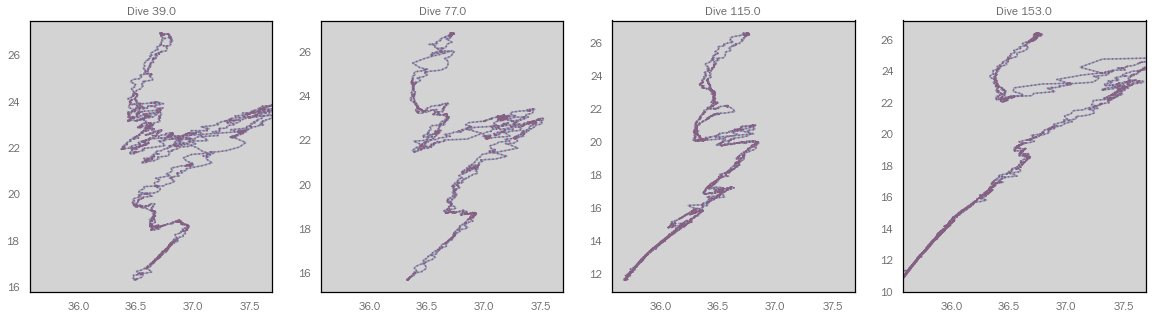

In [10]:
def _verify():
    plt.figure(figsize=(20,5))

    dives = data.data.diveNum.values
    dives = np.unique(dives[np.isfinite(dives)])
    dives = np.round(np.percentile(dives,[20,40,60,80]))

    xlims = np.nanpercentile(data.data.salinity.values,[1,99])

    for idx in range(len(dives)):
        plt.subplot(1,len(dives),idx+1)
        dn = data.data.diveNum==dives[idx]
        plt.plot(data.data.LEGATO_SALINITY[dn],data.data.LEGATO_TEMPERATURE[dn],':r')
        plt.plot(data.data.salinity[dn],data.data.temperature[dn],'-b',alpha=0.5)
        plt.title('Dive '+str(dives[idx]))
        plt.xlim(xlims)

_verify()

## 2.3. Calculate derived variables

### TEOS-10 T&S dependents

In [11]:
# Ancillary variables
def _process(data):
    data['sa'] = gsw.SA_from_SP(data['salinity'].values,data['LEGATO_PRESSURE'].values,data['longitude'].values,data['latitude'].values)
    
    data['ct'] = gsw.CT_from_t(data['sa'].values,data['temperature'].values,data['LEGATO_PRESSURE'].values)
    
    data['sigma0'] = gsw.sigma0(data['sa'].values,data['ct'].values)
    
    data['soundspeed'] = gsw.sound_speed(data['sa'].values,data['ct'].values,data['LEGATO_PRESSURE'].values)
    
    data['depth'] = -gsw.z_from_p(data['LEGATO_PRESSURE'].values,data['latitude'].values)
    
    data['date_float'] = data.Timestamp.values.astype('float')
    
    plog('Calculated T&S derived variables')
    return data

data.data = _process(data.data)

2022-07-15 15:40:18 : Calculated T&S derived variables


### Dissolved oxygen ( TODO )

In [12]:
# Oxygen TODO
# missing lag correction
def _process(data):
    o2_sol = gsw.O2sol(data['sa'],data['ct'],data['LEGATO_PRESSURE'],data['longitude'],data['latitude'])
    o2_sat =  data['AROD_FT_DO'] / gsw.O2sol( data['sa']*0, data['AROD_FT_TEMP'], data['LEGATO_PRESSURE']*0,data['longitude'],data['latitude'])
    data['o2'] = o2_sat * o2_sol
    data['o2_sat'] = o2_sat * 100
    data['aou'] = o2_sol - data['o2']
    plog('Calculated oxygen variables')
    return data
    
data.data = _process(data.data)

2022-07-15 15:40:19 : Calculated oxygen variables


### Optical particulate backscatter

In [13]:
def _process(data):
    def calculate_bbp(beta_total, beam_angle=117, wavelength=700):
        # Scaled output from SeaExplorer gives us Beta for water and particple.
        # https://oceanobservatories.org/wp-content/uploads/2015/10/1341-00540_Data_Product_SPEC_FLUBSCT_OOI.pdf
        beta_sw = byq.betasw_ZHH2009(data.temperature.values,data.salinity.values, wavelength, beam_angle)
        beta_p = beta_total - beta_sw
        Chi_p = 1.08 # For 117* angle (Sullivan & Twardowski, 2009)
        # Chi_p = 1.17 # For 140* angle (Sullivan & Twardowski, 2009)
        bbp = 2 * np.pi * Chi_p * beta_p # in m-1
        return bbp
    
    obs = [x for x in data.columns if ('FL' == x[:2]) & ('_BB_' in x) & ('SCALED' in x)]
    for idx in range(len(obs)):
        var = obs[idx]
        wl = int(''.join(filter(str.isdigit, var)))
        plog('Calculating particulate backscatter at '+str(wl)+' nm.')
        data['bbp_'+str(wl)],_,_ = calculate_bbp(data[var].values, wavelength=wl)
    return data

data.data = _process(data.data)

2022-07-15 15:40:19 : Calculating particulate backscatter at 700 nm.


## 2.4. Define gridding axis based on glider profile times and data range

In [14]:
y_res = 0.5
yaxis = np.arange(0,np.nanmax(np.ceil(data.data.LEGATO_PRESSURE.values)),y_res)
xaxis = data.data.date_float.groupby(data.data.profileNum).agg('mean').index
taxis = pd.to_datetime(data.data.date_float.groupby(data.data.profileNum).agg('mean').values)
days = np.unique(data.data.Timestamp.round('D'))
   
out = {}

# III. ADCP Data Processing

## 3.1. Load ADCP AVG data and xarray adjust coordinates

In [15]:
ADCP = xr.open_mfdataset(adcp_path,group='Data/Average')
ADCP_settings = xr.open_mfdataset(glob(adcp_path)[0],group='Config')
bin_size = ADCP_settings.attrs['avg_cellSize']
blanking_distance = ADCP_settings.attrs['avg_blankingDistance']

In [16]:
ADCP = ADCP.assign_coords(
    Latitude=("time", 
              interp( data.data['Timestamp'].values.astype('float'), data.data['latitude'], ADCP.time.values.astype('float') ) ))

ADCP = ADCP.assign_coords(
    profileNum=("time", 
                np.round(interp(data.data['Timestamp'].values.astype('float'), data.data['profileNum'], ADCP.time.values.astype('float'))) ))

ADCP = ADCP.assign_coords(
    Depth=("time", -gsw.z_from_p(ADCP['Pressure'].values,ADCP['Latitude'].values)))

ADCP = ADCP.assign_coords(
    bin=("Velocity Range", np.arange(len(ADCP['Velocity Range'].values))))
ADCP = ADCP.swap_dims({'Velocity Range':'bin'})

ADCP = ADCP.assign_coords(
    bin=("Correlation Range", np.arange(len(ADCP['Correlation Range'].values))))
ADCP = ADCP.swap_dims({'Correlation Range':'bin'})

ADCP = ADCP.assign_coords(
    bin=("Amplitude Range", np.arange(len(ADCP['Amplitude Range'].values))))
ADCP = ADCP.swap_dims({'Amplitude Range':'bin'})

plog('Finished loading ADCP data')

2022-07-15 15:40:35 : Finished loading ADCP data


## 3.2 Correct ADCP positioning data

### Calculate depth of ADCP bins

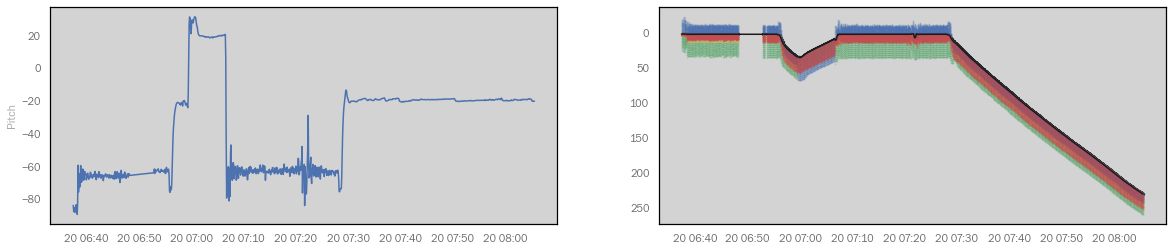

In [17]:
def remapADCPdepth(ADCP, bin_size, blanking_distance, top_mounted=top_mounted):
    if top_mounted:
        direction = 1
        theta_rad_1 = np.arccos(  np.cos(np.deg2rad(47.5 - ADCP['Pitch']))  * np.cos(np.deg2rad(ADCP['Roll']))  )
        theta_rad_2 = np.arccos(  np.cos(np.deg2rad(25 -   ADCP['Roll'] ))  * np.cos(np.deg2rad(ADCP['Pitch']))  )
        theta_rad_3 = np.arccos(  np.cos(np.deg2rad(47.5 + ADCP['Pitch']))  * np.cos(np.deg2rad(ADCP['Roll']))  )
        theta_rad_4 = np.arccos(  np.cos(np.deg2rad(25 +   ADCP['Roll'] ))  * np.cos(np.deg2rad(ADCP['Pitch']))  )
    else:
        direction = -1
        theta_rad_1 = np.arccos(  np.cos(np.deg2rad(47.5 + ADCP['Pitch']))  * np.cos(np.deg2rad(ADCP['Roll']))  )
        theta_rad_2 = np.arccos(  np.cos(np.deg2rad(25 +   ADCP['Roll'] ))  * np.cos(np.deg2rad(ADCP['Pitch']))  )
        theta_rad_3 = np.arccos(  np.cos(np.deg2rad(47.5 - ADCP['Pitch']))  * np.cos(np.deg2rad(ADCP['Roll']))  )
        theta_rad_4 = np.arccos(  np.cos(np.deg2rad(25 -   ADCP['Roll'] ))  * np.cos(np.deg2rad(ADCP['Pitch']))  )
        
    # Upward facing ADCP, so beam 1 ~= 22 deg on the way up, beam 3 on the way down
    # Returns angles of each beam from the UP direction
    
    z_bin_distance = blanking_distance + np.arange(len(ADCP.bin))*bin_size + 0.5*bin_size
    
    ADCP['D1'] = (
                   ['time','bin'],
                   np.tile(ADCP['Depth'], (len(ADCP.bin), 1)).T \
                     - direction \
                     * np.tile(z_bin_distance/np.cos(np.deg2rad(47.5)), (len(ADCP.time), 1)) \
                     * np.tile(np.cos(theta_rad_1), (len(ADCP.bin), 1)).T \
                   )
    ADCP['D2'] = (
                   ['time','bin'],
                   np.tile(ADCP['Depth'], (len(ADCP.bin), 1)).T \
                    - direction \
                    * np.tile(z_bin_distance/np.cos(np.deg2rad(25)), (len(ADCP.time), 1)) \
                    * np.tile(np.cos(theta_rad_2), (len(ADCP.bin), 1)).T \
                  )
    ADCP['D3'] = (
                   ['time','bin'],
                   np.tile(ADCP['Depth'], (len(ADCP.bin), 1)).T \
                    - direction \
                    * np.tile(z_bin_distance/np.cos(np.deg2rad(47.5)), (len(ADCP.time), 1)) \
                    * np.tile(np.cos(theta_rad_3), (len(ADCP.bin), 1)).T \
                  )
    ADCP['D4'] = (
                   ['time','bin'],
                   np.tile(ADCP['Depth'], (len(ADCP.bin), 1)).T \
                    - direction \
                    * np.tile(z_bin_distance/np.cos(np.deg2rad(25)), (len(ADCP.time), 1)) \
                    * np.tile(np.cos(theta_rad_4), (len(ADCP.bin), 1)).T \
                  )  
    
    plt.close('all')
    plt.figure(figsize=(20,4))
    x = np.arange(1000)
    
    times = np.tile(ADCP.time[x].values, (len(ADCP['bin']), 1)).T
    
    plt.subplot(121)
    plt.plot(ADCP.time[x],ADCP.Pitch[x])
    plt.ylabel('Pitch')
    
    plt.subplot(122)
    plt.scatter(ADCP.time[x],ADCP.Pressure[x],5,'k')
    plt.scatter(times.flatten(),ADCP.isel(time=x)['D1'].values.flatten(),1,'g',alpha=0.2)
    plt.scatter(times.flatten(),ADCP.isel(time=x)['D2'].values.flatten(),1,'y',alpha=0.2)
    plt.scatter(times.flatten(),ADCP.isel(time=x)['D3'].values.flatten(),1,'b',alpha=0.2)
    plt.scatter(times.flatten(),ADCP.isel(time=x)['D4'].values.flatten(),1,'r',alpha=0.2)
    plt.plot(ADCP.time[x],ADCP.Pressure[x],'k')

    plt.gca().invert_yaxis()

    return ADCP

ADCP = remapADCPdepth(ADCP,bin_size,blanking_distance)

### ADCP Heading correction

First run
Target = 441.64
Optimization terminated successfully.
         Current function value: 3.940719
         Iterations: 492
         Function evaluations: 718
[[ 8.29461697e-01 -9.90757175e-03 -2.10963841e-03]
 [ 2.13649591e-04  8.51920072e-01  2.66296571e-02]
 [-9.90232794e-03  1.10397623e-02  8.58098768e-01]]
[-0.02744582 -0.00149732  0.01539547]


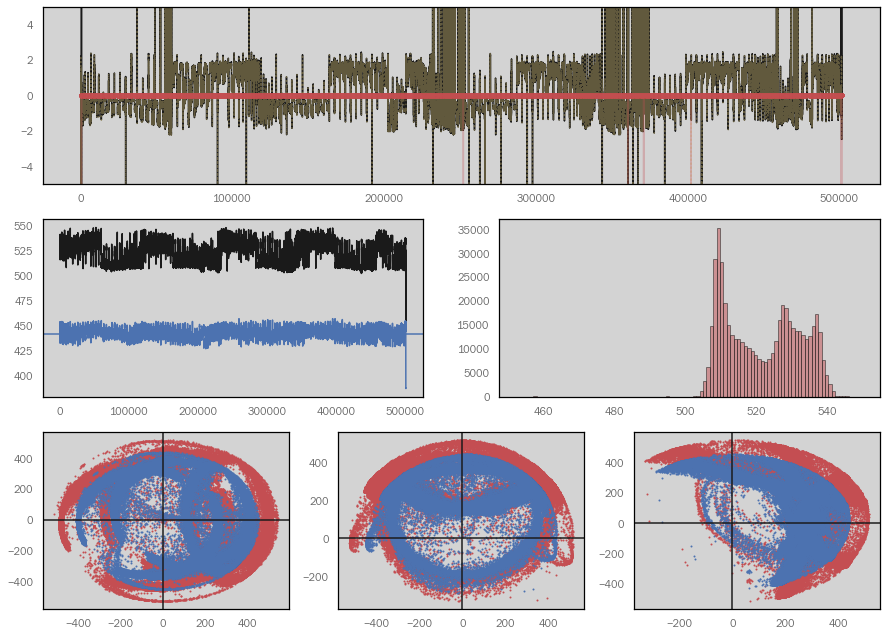

In [18]:
def _process(ADCP):
    
    # # Get local geomagnetic target strength:
    def getGeoMagStrength():    
        lat = np.nanmedian(data.data.latitude)
        lon = np.nanmedian(data.data.longitude)
        date = pd.to_datetime(np.nanmean(data.data.Timestamp.values.astype('float')))
        year = date.year
        month = date.month
        day = date.day

        url = str('https://www.ngdc.noaa.gov/geomag-web/calculators/calculateIgrfwmm?'+
              'lat1='+str(lat)+'&lon1='+str(lon)+
              '&startYear='+str(year)+'&endYear='+str(year)+
              '&startMonth='+str(month)+'&endMonth='+str(month)+
              '&startDay='+str(day)+'&endDay='+str(day)+
              '&resultFormat=csv')

        import urllib
        magdata = urllib.request.urlopen(url)
        string = 'empty'
        while not not string:
            out = magdata.readline().decode("utf-8")
            if not out:
                break
            string = out
        target = float(string.split(',')[4])
        nT2milligauss = 10**-9 * 10000 * 1000 # To tesla, then to gauss then to millgauss
        print('Target = '+str(target*nT2milligauss))
        return target*nT2milligauss
    
    target = getGeoMagStrength()
    
    if top_mounted:
        sign = -1
    else:
        sign = 1
    
    MagX = ADCP['MagnetometerX']
    MagY = sign * ADCP['MagnetometerY']
    MagZ = sign * ADCP['MagnetometerZ']
    
    simple = False
    verysimple = False
    softonly = False
    
    roll = ADCP['Roll']
    pitch = ADCP['Pitch']
    
    norm    = lambda x,y,z : np.sqrt(x**2 + y**2 + z**2)
    rmsd    = lambda x,y,z : np.sqrt( np.mean( ( norm(x,y,z) - target)**2 ) )
    
    cosd    = lambda x : np.cos(np.deg2rad(x))
    sind    = lambda x : np.sin(np.deg2rad(x))
    atan2d  = lambda x,y : np.rad2deg(np.arctan2(x,y))
    rot_x   = lambda x,y,z : x*cosd(pitch) + y*sind(roll)*sind(pitch) + z*cosd(roll)*sind(pitch)
    rot_y   = lambda x,y,z : y*cosd(roll) - z*sind(roll)
    wrap    = lambda x : (x+360)%360
    heading = lambda x,y,z : wrap( atan2d(rot_x(x,y,z),rot_y(x,y,z)) - 90 )
    
    def calibrate(x,y,z,coeffs):
        if simple:
            coeffs[[1,2,3,5,6,7]] = 0
        if verysimple:
            coeffs[:9] = 0
            coeffs[[0,4,8]] = 1
        if softonly:
            coeffs[-3:] = 0
            
        A = np.reshape(coeffs[:9],(3,3))
        B = coeffs[-3:]
        out = A @ np.array([x-B[0], y-B[1], z-B[2]])
        return out[0,:],out[1,:],out[2,:]
    
    def minimisation(coeffs):
        x,y,z = calibrate(MagX,MagY,MagZ,coeffs)
        return rmsd(x,y,z)
    
    coeffs = fmin(minimisation,np.array([1,0,0,0,1,0,0,0,1,0,0,0]))
    print(np.reshape(coeffs[:9],(3,3)))
    print(coeffs[-3:])
    
    magx,magy,magz = calibrate(MagX.values, MagY.values, MagZ.values,coeffs)
    cal_heading = heading(magx,magy,magz)
    
    %matplotlib inline
    plt.figure(figsize=(15,15))
    
    plt.subplot(411)
    plt.plot(cal_heading - ADCP.Heading,'-k')
    plt.plot(cal_heading - heading(MagX.values, MagY.values, MagZ.values),':y',alpha=0.4)
    plt.plot(ADCP.Heading - heading(MagX.values, MagY.values, MagZ.values),'-r.',alpha=0.3)
    plt.ylim([-5,5])
    
    plt.subplot(423)
    plt.plot(norm(MagX.values, MagY.values, MagZ.values),'-k')
    plt.plot(norm(magx,magy,magz),'-b')
    plt.axhline(target)
    
    plt.subplot(424)
    bins = np.linspace(500,550,100)
    _ = plt.hist(norm(magx,magy,magz),bins, color='b', alpha=0.5)
    _ = plt.hist(norm(MagX.values, MagY.values, MagZ.values),100, color='r', alpha=0.5)
    
    plt.subplot(437)
    plt.axvline(0,color='k')
    plt.axhline(0,color='k')
    plt.scatter(MagX.values, MagY.values, 1, 'r')
    plt.scatter(magx,magy, 1, 'b')
    
    plt.subplot(438)
    plt.axvline(0,color='k')
    plt.axhline(0,color='k')
    plt.scatter(MagY.values, MagZ.values, 1, 'r')
    plt.scatter(magy,magz, 1, 'b')
    
    plt.subplot(439)
    plt.axvline(0,color='k')
    plt.axhline(0,color='k')
    plt.scatter(MagZ.values, MagX.values, 1, 'r')
    plt.scatter(magz,magx, 1, 'b')
    
    cal_heading = cal_heading
    mag_bias = norm(magx,magy,magz)-target
    
    return cal_heading


if options['correctADCPHeading']:
    try:
        ADCP['Heading'] = ('time', ADCP['Heading_old'].values)
        print('Resetting to original heading')
    except:
        print('First run')
    ADCP['Heading_old'] = ('time', ADCP['Heading'].values)
    ADCP['Heading'] = ('time', _process(ADCP).values + interp(
            data.data['Timestamp'].values.astype('float'), data.data['Declination'], ADCP.time.values.astype('float')
            ))

## 3.3. Correct ADCP velocity data

### Sound speed correction

In [19]:
def _process(ADCP):  
    try:
        true_ss = interp(data.data['date_float'].values, data.data['soundspeed'], ADCP.time.values.astype('float'))
        ADCP = ADCP.rename({'SpeedOfSound':'Raw_SpeedOfSound'})        
        ADCP['SpeedOfSound'] = ('time',true_ss)
        ADCP['SpeedOfSound'] = ADCP['SpeedOfSound'].interp()
        for beam in ['1','2','3','4']:
            # V_new = V_old * (c_new/c_old)
            ADCP['VelocityBeam'+beam] = ADCP['VelocityBeam'+beam] * (ADCP['SpeedOfSound'] / ADCP['Raw_SpeedOfSound'])
            plog('Corrected beam '+beam+' velocity for sound speed.')
    except:
        plog('Speed of sound correction has already been applied')
        
    return ADCP

ADCP = _process(ADCP)

2022-07-15 15:41:11 : Corrected beam 1 velocity for sound speed.
2022-07-15 15:41:11 : Corrected beam 2 velocity for sound speed.
2022-07-15 15:41:11 : Corrected beam 3 velocity for sound speed.
2022-07-15 15:41:11 : Corrected beam 4 velocity for sound speed.


### Outlier and poor correlation removal

In [20]:
if options['ADCP_discardFirstBin']: print(ADCP.dims); ADCP = ADCP.isel(bin = ADCP['bin'] > 0); print(ADCP.dims); plog('Discarded bin 0 from ADCP data')

Frozen({'time': 501467, 'bin': 12, 'Physicalbeam_dim': 4})
Frozen({'time': 501467, 'bin': 11, 'Physicalbeam_dim': 4})
2022-07-15 15:41:11 : Discarded bin 0 from ADCP data


In [21]:
# From Tanaka:
# the velocity was 0.5 m s-1 or less,
# the echo intensity (or amplitude) was 75 dB or less,
# the percent-good was 80 or greater,
# the signal-to-noise ratio (SNR) was 20 or greater.

for beam in ['1','2','3','4']:
    C = ADCP['CorrelationBeam'+beam].values.copy()
    C[C < options['ADCP_correlationThreshold']] = np.NaN
    C[np.isfinite(C)] = 1
    
    A = ADCP['AmplitudeBeam'+beam].values.copy()
    A[A > options['ADCP_amplitudeThreshold']] = np.NaN
    # A[A < 40] = np.NaN
    A[np.isfinite(A)] = 1
    
    V = ADCP['VelocityBeam'+beam].values.copy()
    V[np.abs(V) > options['ADCP_velocityThreshold']] = np.NaN
    V[np.isfinite(V)] = 1
    
    Sh_threshold = 3
    Sh = np.append(ADCP['VelocityBeam'+beam].diff(dim='bin').values, np.zeros([len(ADCP['time']),1]), axis=1 ) + np.insert(ADCP['VelocityBeam'+beam].diff(dim='bin').values, 0, np.zeros([1,len(ADCP['time'])]), axis=1 )
    #print(np.nanpercentile(Sh,[Sh_threshold, 100-Sh_threshold]))
    Sh[Sh < np.nanpercentile(Sh,Sh_threshold)] = np.NaN
    Sh[Sh > np.nanpercentile(Sh,100 - Sh_threshold)] = np.NaN
    Sh[np.isfinite(Sh)] = 1
    
    ADCP['VelocityBeam'+beam] = ADCP['VelocityBeam'+beam]*C*A*V*Sh
    
    plog('Outlier removal for beam '+beam)

2022-07-15 15:41:12 : Outlier removal for beam 1
2022-07-15 15:41:13 : Outlier removal for beam 2
2022-07-15 15:41:14 : Outlier removal for beam 3
2022-07-15 15:41:15 : Outlier removal for beam 4


### Correct shear bias

In [22]:
### Defining coordinate transform functions for the 4 beam ADCP configuration
def quad_beam2xyzz_mat():
    M11=0.6782; M12=0.0000; M13=-0.6782; M14=0.0000
    M21=0.0000; M22=-1.1831; M23=0.0000; M24=1.1831
    M31=0.7400; M32=0.0000; M33=0.7400; M34=0.0000
    M41=0.0000; M42=0.5518; M43=0.0000; M44=0.5518
    T = np.array([[M11,M12,M13,M14], [M21,M22,M23,M24], [M31,M32,M33,M34], [M41,M42,M43,M44]])
    if not top_mounted:
        T[1:,:] = -T[1:,:]
    return T

def quad_beam2xyzz(B1,B2,B3,B4):
    T = quad_beam2xyzz_mat()
    try:
        r,c = np.shape(B1.values)
    except:
        c = 1; r = len(B1.values)
    V = np.array([B1.values.flatten(),
                  B2.values.flatten(),
                  B3.values.flatten(),
                  B4.values.flatten()
                 ])
    XYZZ = V*0
    for col in np.arange(V.shape[1]):
        XYZZ[:,col] = T@V[:,col]   
    return np.reshape(XYZZ[0,:],[r,c]),np.reshape(XYZZ[1,:],[r,c]),np.reshape(XYZZ[2,:],[r,c]),np.reshape(XYZZ[3,:],[r,c])

def quad_xyzz2beam(X,Y,Z,ZZ):
    T = np.linalg.inv(quad_beam2xyzz_mat())
    r,c = np.shape(X.values)
    XYZZ = np.array([X.values.flatten(),
                  Y.values.flatten(),
                  Z.values.flatten(),
                  ZZ.values.flatten()
                 ])
    V = XYZZ*0
    for col in np.arange(XYZZ.shape[1]):
        V[:,col] = T@XYZZ[:,col]   
    return np.reshape(V[0,:],[r,c]),np.reshape(V[1,:],[r,c]),np.reshape(V[2,:],[r,c]),np.reshape(V[3,:],[r,c])

def do_xyzz2beam(ADCP):
    V = quad_xyzz2beam(ADCP['X4'],ADCP['Y4'],ADCP['Z4'],ADCP['ZZ4'])
    ADCP['VelocityBeam1'] = (['time','bin'], V[0])
    ADCP['VelocityBeam2'] = (['time','bin'], V[1])
    ADCP['VelocityBeam3'] = (['time','bin'], V[2])
    ADCP['VelocityBeam4'] = (['time','bin'], V[3])
    return ADCP
    
def do_beam2xyzz(ADCP):
    XYZZ = quad_beam2xyzz(ADCP['VelocityBeam1'],ADCP['VelocityBeam2'],ADCP['VelocityBeam3'],ADCP['VelocityBeam4'])
    ADCP['X4'] = (['time','bin'], XYZZ[0])
    ADCP['Y4'] = (['time','bin'], XYZZ[1])
    ADCP['Z4'] = (['time','bin'], XYZZ[2])
    ADCP['ZZ4'] = (['time','bin'], XYZZ[3])
    return ADCP

def plotit():
    plt.figure(figsize=(7,3))
    ADCP['X4'].diff(dim='bin').mean(dim='time').plot()
    ADCP['Y4'].diff(dim='bin').mean(dim='time').plot()
    ADCP['Z4'].diff(dim='bin').mean(dim='time').plot()
    ADCP['ZZ4'].diff(dim='bin').mean(dim='time').plot()
    plt.legend(('X','Y','Z','ZZ'))
    plt.ylim(np.array([-1,1])*1e-3)

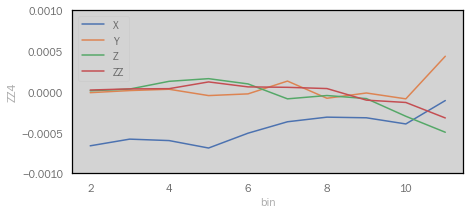

In [23]:
def shear_correction(var,correct=True):
    def get_correction_array(row):
        ### SEPARATION CRITERIA
        spd_thr_water = np.sqrt(ADCP['X4']**2 + ADCP['Y4']**2 + ((ADCP['Z4']+ADCP['ZZ4'])/2)**2)

        spd = spd_thr_water.values[:,0] #.values[:,5] #.mean('bin')

        range_interval = 0.01
        full_range = np.arange(0.2,0.3,range_interval)   # OMAN BEST: np.arange(0.2,0.3,range_interval)
        cmaps = np.arange(len(full_range))/len(full_range)

        ### WHAT TO PLOT
        variable = ADCP[var]
        _gd = (ADCP['Depth'] > 5)

        ### MAKE FIGURE
        colormap = cmo.speed
        alpha = 30/len(full_range)
        if alpha > 1.:
            alpha=0.5

        plt.subplot(2,3,1+row)
        sz = plt.hist(spd, bins = np.append(full_range, np.max(full_range)+range_interval)-(range_interval/2))[0]
        sz = sz/np.max(sz) * 50

        plt.subplot(2,3,2+row)
        x = []; y = []; c = []; s = []
        for idx,range_level in enumerate(full_range):
            color = colormap(cmaps[idx])
            ind = (np.abs(spd-range_level) < (range_interval/2)) & _gd
            arr = variable.isel(time=ind).mean('time').values
            plt.plot(arr, color=color, alpha=alpha)

            x.append(np.arange(len(arr)))
            y.append(arr)
            c.append(arr*0 + range_level)
            s.append(arr*0 + sz[idx])

        plt.plot(variable.isel(time=(spd > full_range[0]) & (spd < full_range[-1])).mean('time').values, color='r', linewidth=4)
        plt.scatter(x,y,s,c, cmap=colormap)
        plt.colorbar()
        plt.grid('on')

        plt.subplot(2,3,3+row)
        x = []; y = []; c = []; s = []
        for idx,range_level in enumerate(full_range):
            color = colormap(cmaps[idx])
            ind = (np.abs(spd-range_level) < (range_interval/2)) & _gd
            arr = variable.isel(time=ind).diff('bin').mean('time').values
            plt.plot(arr, color=color, alpha=alpha)

            x.append(np.arange(len(arr)))
            y.append(arr)
            c.append(arr*0 + range_level)
            s.append(arr*0 + sz[idx])

        plt.plot(variable.isel(time=(spd > full_range[0]) & (spd < full_range[-1])).diff('bin').mean('time').values, color='r', linewidth=4)
        plt.scatter(x,y,s,c, cmap=colormap)
        plt.colorbar()
        plt.axhline(0, color='k')
        plt.grid('on')
        plt.ylim(np.array([-1,1])*0.001)

        
        ref = np.cumsum(np.insert(variable.isel(time=(spd > full_range[0]) & (spd < full_range[-1])).diff('bin').mean('time').values,0,0))
        ref = ref - np.nanmean(ref)
        
        return ref
    
    plt.figure(figsize=(20,6))
    
    if correct:
        ADCP[var] = ADCP[var] - get_correction_array(0)
        _ = get_correction_array(3)
        plog('Corrected '+var)
    else:
        _ = get_correction_array(0)
    
    return None



ADCP = do_beam2xyzz(ADCP)
plotit()

if options['correctZZshear']: ADCP = do_beam2xyzz(ADCP); shear_correction('ZZ4'); ADCP = do_xyzz2beam(ADCP);
if options['correctZshear']: ADCP = do_beam2xyzz(ADCP); shear_correction('Z4'); ADCP = do_xyzz2beam(ADCP);
if options['correctYshear']: ADCP = do_beam2xyzz(ADCP); shear_correction('Y4'); ADCP = do_xyzz2beam(ADCP);
if options['correctXshear']: ADCP = do_beam2xyzz(ADCP); shear_correction('X4'); ADCP = do_xyzz2beam(ADCP);

if options['correctZZshear'] or options['correctZshear'] or options['correctYshear'] or options['correctXshear']: plotit();

### Pitching motion correction (TODO)

In [24]:
# def ADCP_rotation_correction():
#     ADCP['dPitch_dt'] = (['time'], np.gradient(np.deg2rad(ADCP.Pitch.values),ADCP.time.values.astype('float')/(10**9)))
#     dx=0.4
#     dz=0.125
#     a=47.5
#     b=25
#     ADCP['VelocityBeam1'] = ADCP['VelocityBeam1'] + ADCP['dPitch_dt']*(-dz * np.sin(np.deg2rad(a)) + dx * np.cos(np.deg2rad(a)))
#     ADCP['VelocityBeam3'] = ADCP['VelocityBeam3'] + ADCP['dPitch_dt']*( dz * np.sin(np.deg2rad(a)) + dx * np.cos(np.deg2rad(a)))
#     ADCP['VelocityBeam2'] = ADCP['VelocityBeam2'] + ADCP['dPitch_dt']*( dx * np.cos(np.deg2rad(b)) )
#     ADCP['VelocityBeam4'] = ADCP['VelocityBeam4'] + ADCP['dPitch_dt']*( dx * np.cos(np.deg2rad(b)) )

# # ADCP_rotation_correction()
# ### NOT RUNNING AS PROBABLY CODED FOR UPWARD FACING ADCP

## 3.4. Correct ADCP acoustic backscatter data (TODO)

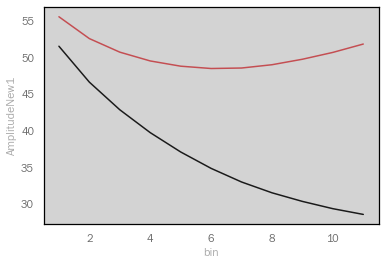

In [25]:
# https://www.sciencedirect.com/science/article/pii/S0278434304002171#fig2
# 2.1. Intensity correction

# For a single acoustic target, intensity falls proportional to distance squared. 
# For volume scattering, on the other hand, approximately half of the loss is 
# cancelled by the increasing number of (zooplankton) targets ensonified by the 
# spreading beam. Defining  and  as the corrected and measured ADCP beam intensity, 
# respectively, the correction for volume scattering is given by

# I(c) = I(m) + 2( 10 * log(r) + alpha * r )

# with r the distance from the transducer to each of the depth bins, alpha the
# absorption, or attenuation, coefficient, and where the extra factor of 2 accounts for 
# the return trip the sound pulse must make. For single target scattering, the correction
# recommended by RDI, the 10 in Eq. (1) is replaced with 20; this correction has been used,
# for example, by Thomson and Allen (2000), who examined macrozooplankton migration and 
# fish abundance. The rate of absorption in seawater is a function of pressure, temperature,
# salinity, pH, and sound frequency; using the empirical equation derived by Francois and 
# Garrison (1982) for a depth of 100 m, , and  for the ADCP frequency of 307 kHz.


def francoisgarrison(freq=None,S=None,T=None,pH=8.1,z=None):
    # Underwater acoustics: calculation of the absorption coefficient
    #
    # SYNTAX: a = francoisgarrison(freq,T,S,pH,z)
    # Units: [freq] = kHz, [T] = Celsius, [S] = ppt, [z] = m, [a] = dB/m
    # 
    # Reference: 
    # Sound absorption based on ocean measurements. Part II: Boric acid contribution 
    # and equation for total absorption 
    # R.E. Francois and G. R. Garrison
    # J. Acoust. Soc. Am. 72(6), December 1982
    
    #*******************************************************************************
    # Faro, Ter Set  7 23:46:58 WEST 2021
    # Written by Orlando Camargo Rodriguez
    #*******************************************************************************
    c   = 1412.0 + 3.21*T + 1.19*S + 0.0167*z
    theta = 273.0 + T
    fxf = freq**2
    f1 = 2.8*np.sqrt(S/35.0)*10**(4.0-1245.0/theta)
    f2 = 8.17*10**(8.0-1990.0/theta)/( 1.0 + 0.0018*(S-35.0) )
    A1 = 8.86/c*10**(0.78*pH-5)
    A2 = 21.44*S/c*( 1.0 + 0.025*T )
    A3 = 3.964e-4 - 1.146e-5*T + 1.45e-7*T**2 - 6.5e-10*T**3
    ind = (T <= 20)
    A3[ind] = 4.937e-4 - 2.59e-5*T[ind] + 9.11e-7*T[ind]**2 - 1.50e-8*T[ind]**3
    P1 = 1.0
    P2 = 1 - 1.35e-4*z + 6.2e-9*z**2
    P3 = 1 - 3.83e-5*z + 4.9e-10*z**2
    alpha = A1*P1*f1*fxf/( f1**2 + fxf ) + A2*P2*f2*fxf/( f2**2 + fxf ) + A3*P3*fxf
    return alpha/1000

a = np.cos(np.deg2rad(47.4)) # Beam 1 and 3 angle from Z 47.5
b = np.cos(np.deg2rad(25))   # Beam 2 and 4 angle from Z 25

ADCP['BeamRange1']=('bin',ADCP['Velocity Range'].values / a )
ADCP['BeamRange2']=('bin',ADCP['Velocity Range'].values / b )
ADCP['BeamRange3']=('bin',ADCP['Velocity Range'].values / a )
ADCP['BeamRange4']=('bin',ADCP['Velocity Range'].values / b )
    
ADCP['AcousticAttenuation'] = ('time', 
                               francoisgarrison(
                                   freq=1000,
                                   S=interp(data.data.Timestamp.values.astype('float'), data.data.salinity.interpolate('index').fillna(method='bfill').values, ADCP.time.values.astype('float')),
                                   T=interp(data.data.Timestamp.values.astype('float'), data.data.temperature.interpolate('index').fillna(method='bfill').values, ADCP.time.values.astype('float')),
                                   pH=8.1,
                                   z=ADCP['Depth'].values)
                              )

for beam in ['1','2','3','4']:
    # ADCP['AmplitudeNew'+beam] = (['time','bin'], (0.43*ADCP['AmplitudeBeam'+beam] + 20*np.log(ADCP['BeamRange'+beam]) + 2*ADCP['AcousticAttenuation']*ADCP['BeamRange'+beam]).values)# + 20 int(particule attenuation,range)
    ADCP['AmplitudeNew'+beam] = (['time','bin'], (ADCP['AmplitudeBeam'+beam] + 2*ADCP['AcousticAttenuation']*ADCP['BeamRange'+beam]).values)# + 20 int(particule attenuation,range)
    
ADCP['AmplitudeBeam1'].mean('time').plot(color='k')
ADCP['AmplitudeNew1'].mean('time').plot(color='r')

In [26]:
ADCP


<xarray.Dataset>
Dimensions:                    (time: 501467, bin: 11, Physicalbeam_dim: 4)
Coordinates:
  * time                       (time) datetime64[ns] 2021-11-20T06:37:26.4382...
    Velocity Range             (bin) float32 4.2 6.2 8.2 10.2 ... 20.2 22.2 24.2
    Correlation Range          (bin) float32 4.2 6.2 8.2 10.2 ... 20.2 22.2 24.2
    Amplitude Range            (bin) float32 4.2 6.2 8.2 10.2 ... 20.2 22.2 24.2
    Latitude                   (time) float64 24.13 24.13 24.13 ... nan nan nan
    profileNum                 (time) float64 1.0 1.0 1.0 1.0 ... nan nan nan
    Depth                      (time) float64 1.844 1.805 1.821 ... nan nan nan
  * bin                        (bin) int32 1 2 3 4 5 6 7 8 9 10 11
Dimensions without coordinates: Physicalbeam_dim
Data variables: (12/62)
    VelocityBeam1              (time, bin) float64 dask.array<chunksize=(250691, 11), meta=np.ndarray>
    VelocityBeam2              (time, bin) float64 dask.array<chunksize=(250691, 11), meta=np.ndarray>
    VelocityBeam3              (time, bin) float64 dask.array<chunksize=(250691, 11), meta=np.ndarray>
    VelocityBeam4              (time, bin) float64 dask.array<chunksize=(250691, 11), meta=np.ndarray>
    CorrelationBeam1           (time, bin) float32 dask.array<chunksize=(250691, 11), meta=np.ndarray>
    CorrelationBeam2           (time, bin) float32 dask.array<chunksize=(250691, 11), meta=np.ndarray>
    ...                         ...
    BeamRange4                 (bin) float32 4.634 6.841 9.048 ... 24.49 26.7
    AcousticAttenuation        (time) float64 0.3375 0.3376 0.3376 ... nan nan
    AmplitudeNew1              (time, bin) float64 63.19 59.68 58.18 ... nan nan
    AmplitudeNew2              (time, bin) float64 61.13 58.12 56.61 ... nan nan
    AmplitudeNew3              (time, bin) float64 63.19 61.68 60.18 ... nan nan
    AmplitudeNew4              (time, bin) float64 74.63 65.62 58.61 ... nan nan

## 3.5. Remap 3-beam configuration onto isobars

Using the following depth offsets:
[ -1.2  -2.2  -3.2  -4.2  -5.2  -6.2  -7.2  -8.2  -9.2 -10.2 -11.2 -12.2
 -13.2 -14.2 -15.2 -16.2 -17.2 -18.2 -19.2 -20.2 -21.2 -22.2]
 
Running gridding on all 4 beams:
2022-07-15 15:41:31 : Calculating beam 1
2022-07-15 15:42:01 : Calculating beam 2
2022-07-15 15:42:30 : Calculating beam 3
2022-07-15 15:42:59 : Calculating beam 4


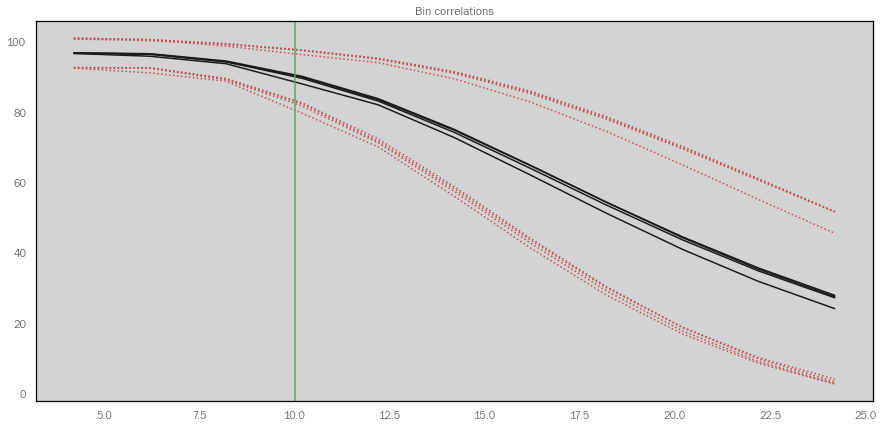

In [27]:
## This is to avoid shear smearing because of tilted ADCP
def regridADCPdata(ADCP, bin_size, blanking_distance, depth_offsets=None):   
    
    ## FN: calculate isobar offsets relative to glider depth for each ping
    def calc_ideal_depth_offsets(bin_size, blanking_distance):
        if top_mounted:
            direction = 1
        else:
            direction = -1
        threshold = 20
        means = [np.nanmean(ADCP['CorrelationBeam'+str(x)],axis=0) for x in [1,2,3,4]]
        stds = [np.nanstd(ADCP['CorrelationBeam'+str(x)],axis=0) for x in [1,2,3,4]]

        max_bin = np.argmin(abs(np.nanmean([means[x] for x in range(4)],axis=0)  - threshold))
        max_distance = blanking_distance + max_bin*bin_size + 0.5*bin_size

        plt.close('all')
        plt.figure(figsize=(15,7))
        [plt.plot(ADCP['Correlation Range'].values,means[x],'-k') for x in range(4)]
        [plt.plot(ADCP['Correlation Range'].values,means[x]+stds[x],':r') for x in range(4)]
        [plt.plot(ADCP['Correlation Range'].values,means[x]-stds[x],':r') for x in range(4)]
        plt.axvline(max_bin,color='g')
        plt.title('Bin correlations')

        return np.arange(blanking_distance + bin_size/2, max_distance+bin_size, bin_size/2)*direction

    ## Calculate desired interpolation depth offsets
    if depth_offsets is None:
        depth_offsets = calc_ideal_depth_offsets(bin_size, blanking_distance)
        
    print('Using the following depth offsets:')
    print(depth_offsets)
    print(' ')
    print('Running gridding on all 4 beams:')
    
    ## Extract to np array for speed
    adcp_depth = ADCP['Depth'].values
        
    for beam in ['1','2','3','4']:
        plog('Calculating beam '+beam)
        def interp1d_np(x,y):
            _gd = np.isfinite(y)
            if np.count_nonzero(_gd) > 1:
                xi = interp1d(x[_gd], y[_gd], bounds_error=False, fill_value=np.NaN)(depth_offsets)
            else:
                xi = depth_offsets * np.NaN
            return xi
        
        ADCP.load()
        ADCP['V'+beam] = xr.apply_ufunc(
            interp1d_np,
            ADCP['Depth']-ADCP['D'+beam],
            ADCP['VelocityBeam'+beam],
            input_core_dims=[['bin'],['bin']],
            output_core_dims=[['gridded_bin']],
            exclude_dims=set(("bin",)),
            vectorize=True,
            output_sizes={'gridded_bin': len(depth_offsets)},
        )        
        
    ADCP = ADCP.assign_coords({'depth_offset':(['gridded_bin'], depth_offsets)})
    ADCP = ADCP.assign_coords({'bin_depth':(['time','gridded_bin'], 
                                     np.tile(ADCP['Depth'].values.astype('float'), (len(ADCP.gridded_bin), 1)).T
                                     - np.tile(depth_offsets, (len(ADCP.time), 1))
                                    )})
    
    ## Discard everything that wasn't gridded
    ADCP = ADCP.drop(labels=['D1','D2','D3','D4',
                             'CorrelationBeam1','CorrelationBeam2','CorrelationBeam3','CorrelationBeam4',
                             'VelocityBeam1','VelocityBeam2','VelocityBeam3','VelocityBeam4',
                             'AmplitudeBeam1','AmplitudeBeam2','AmplitudeBeam3','AmplitudeBeam4'])
    return ADCP

ADCP = regridADCPdata(ADCP, bin_size, blanking_distance)
# ADCP

## 3.6. Transform beams to XYZ and ENU velocities

Assuming ADCP is bottom mounted
2022-07-15 15:43:30 : Calculating X,Y,Z from isobaric 3-beam measurements.


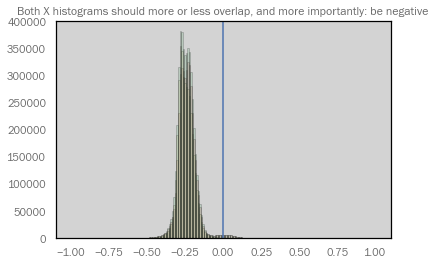

In [28]:
def calcXYZfrom3beam():
    def sin(x):
        return np.sin(np.deg2rad(x))
    def cos(x):
        return np.cos(np.deg2rad(x))

    a = 47.5 # Beam 1 and 3 angle from Z
    b = 25 # Beam 2 and 4 angle from Z

    xyz2beam_fore = np.array([
        [sin(a),0,cos(a)],
        [0,-sin(b),cos(b)],
        [0,sin(b),cos(b)]
    ])
    xyz2beam_aft = np.array([
        [-sin(a),0,cos(a)],
        [0,-sin(b),cos(b)],
        [0,sin(b),cos(b)]
    ])

    beam2xyz_fore = np.linalg.inv(xyz2beam_fore)
    beam2xyz_aft = np.linalg.inv(xyz2beam_aft)

    V_fore = beam2xyz_fore @ np.array([
        ADCP['V1'].values.flatten(),
        ADCP['V2'].values.flatten(),
        ADCP['V4'].values.flatten()
        ])
    V_aft = beam2xyz_aft @ np.array([
        ADCP['V3'].values.flatten(),
        ADCP['V2'].values.flatten(),
        ADCP['V4'].values.flatten()
        ])

    if rmsd(V_aft[1:,:]-V_fore[1:,:]) != 0:
        plt.plot(V_aft[1:,:]-V_fore[1:,:],'-kx')
        print(rmsd(V_aft[1:,:]-V_fore[1:,:]))
        plog('Something is wrong - abort and investigate...')

    X_fore = np.reshape( V_fore[0,:] , np.shape(ADCP['V1']) )
    X_aft = np.reshape( V_aft[0,:] , np.shape(ADCP['V1']) )
    
    plt.close('all')
    _ = plt.hist(X_fore.flatten(),np.linspace(-1,1,200),color='r',alpha=0.2)
    _ = plt.hist(X_aft.flatten(),np.linspace(-1,1,200),color='y',alpha=0.2)
    plt.axvline(0)
    plt.title('Both X histograms should more or less overlap, and more importantly: be negative')
    
    use_aft_on_climb = ADCP['Pitch'] > 0
    
    X = X_fore.copy()
    
    if top_mounted == True:
        print('Assuming ADCP is top mounted')
        X[~use_aft_on_climb,:] = X_aft[~use_aft_on_climb,:]
    else:
        print('Assuming ADCP is bottom mounted')
        X[use_aft_on_climb,:] = X_aft[use_aft_on_climb,:]
    
    
    _ = plt.hist(X.flatten(),np.linspace(-1,1,200),color='g',alpha=0.2)
    
    ADCP['X'] = (['time','gridded_bin'], X )
    ADCP['Y'] = (['time','gridded_bin'], np.reshape( V_aft[1,:] , np.shape(ADCP['V1']) ) )
    ADCP['Z'] = (['time','gridded_bin'], np.reshape( V_aft[2,:] , np.shape(ADCP['V1']) ) )
    
    plog('Calculating X,Y,Z from isobaric 3-beam measurements.')
    
    
calcXYZfrom3beam()

In [29]:
def calcENUfromXYZ():
    def M_xyz2enu(heading,pitch,roll):
        hh = np.pi*(heading-90)/180
        pp = np.pi*pitch/180
        rr = np.pi*roll/180

        _H = np.array([
            [np.cos(hh),np.sin(hh),0], 
            [-np.sin(hh),np.cos(hh),0], 
            [0,0,1]
        ])
        _P = np.array([
            [np.cos(pp), 0, -np.sin(pp)] ,
            [0, 1, 0] , 
            [ np.sin(pp), 0, np.cos(pp)]
        ])
        _R = np.array([
            [1, 0, 0] ,
            [0, np.cos(rr), -np.sin(rr)] , 
            [0, np.sin(rr), np.cos(rr)]
        ])

        _M = _H@_P@_R
        return _M

    H = ADCP['Heading'].values
    P = ADCP['Pitch'].values
    R = ADCP['Roll'].values

    if top_mounted:
        direction = 1
    else:
        direction = -1
        
    E = ADCP['X'].values.copy()
    N = ADCP['Y'].values.copy()*direction
    U = ADCP['Z'].values.copy()*direction

    r,c = np.shape(E)
    
    for i in tqdm(range(r)):
        XYZ2ENU = M_xyz2enu(H[i],P[i],R[i])
        for j in range(c):
            E[i,j], N[i,j], U[i,j] = XYZ2ENU @ [E[i,j], N[i,j], U[i,j]]   
    

    ADCP['E'] = (['time','gridded_bin'], E )
    ADCP['N'] = (['time','gridded_bin'], N )
    ADCP['U'] = (['time','gridded_bin'], U )
    
    plog('Converted from XYZ to ENU')

calcENUfromXYZ()

100%|████████████████████████████████| 501467/501467 [01:08<00:00, 7282.39it/s]

2022-07-15 15:44:40 : Converted from XYZ to ENU


234405 228866


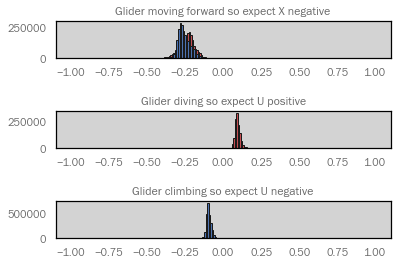

In [30]:
def verify():
    plt.figure()

    PD = (ADCP['Pitch'].values < 0) & (ADCP['Depth'].values > 20)
    PU = (ADCP['Pitch'].values > 0) & (ADCP['Depth'].values > 20)

    print(np.count_nonzero(PD),np.count_nonzero(PU))

    plt.subplot(511)
    _ = plt.hist(ADCP.isel(time=PD)['X'].values.flatten(),np.linspace(-1,1,200),color='r')
    _ = plt.hist(ADCP.isel(time=PU)['X'].values.flatten(),np.linspace(-1,1,200),color='b')
    plt.title('Glider moving forward so expect X negative')

    plt.subplot(513)
    _ = plt.hist(ADCP.isel(time=PD)['U'].values.flatten(),np.linspace(-1,1,200),color='r')
    plt.title('Glider diving so expect U positive')

    plt.subplot(515)
    _ = plt.hist(ADCP.isel(time=PU)['U'].values.flatten(),np.linspace(-1,1,200),color='b')
    plt.title('Glider climbing so expect U negative')
    
verify()

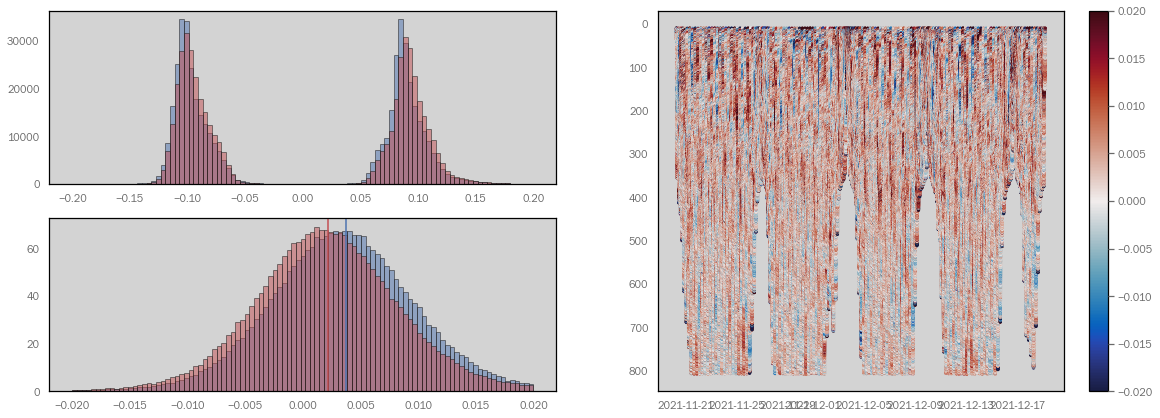

In [31]:
def _verify():

    _gd = (ADCP['Pressure'].values > 10)
    
    PD = (ADCP.isel(time=_gd)['Pitch'].values < 0) & (ADCP.isel(time=_gd)['Depth'].values > 20)
    PU = (ADCP.isel(time=_gd)['Pitch'].values > 0) & (ADCP.isel(time=_gd)['Depth'].values > 20)

    T = ADCP.isel(time=_gd)['time']
    D = ADCP.isel(time=_gd)['Depth']
    R = ADCP.isel(time=_gd)['Roll']
    U = ADCP.isel(time=_gd)['U'].mean(dim='gridded_bin').values.flatten()# * 1.009
    dP = np.gradient(ADCP.isel(time=_gd)['Depth'].values, ADCP.isel(time=_gd)['time'].astype('float')/1e9)
    
    bins = np.linspace(-1,1,100)*0.2
    
    plt.figure(figsize=(20,7))
    plt.subplot(221)
    _ = plt.hist(U,bins,color='b',alpha=0.5)
    _ = plt.hist(dP,bins,color='r',alpha=0.5)
    
    plt.subplot(223)
    _ = plt.hist((dP-U)[PD],bins/10,density=True,color='b',alpha=0.5)
    _ = plt.hist((dP-U)[PU],bins/10,density=True,color='r',alpha=0.5)
    plt.axvline(np.nanmean((dP-U)[PD]),color='b')
    plt.axvline(np.nanmean((dP-U)[PU]),color='r')
    
    plt.subplot(122)
    plt.scatter(T,D,5,dP-U, cmap=cmo.balance)
    plt.colorbar()
    plt.clim([bins[0]/10,bins[-1]/10])
    plt.gca().invert_yaxis()
    
    
_verify()

## 3.7. Calculate shear

In [32]:
ADCP['Sh_E'] = (['time','gridded_bin'],
                  ADCP['E'].differentiate('gridded_bin').values
                 )
ADCP['Sh_N'] = (['time','gridded_bin'],
                  ADCP['N'].differentiate('gridded_bin').values
                 )
ADCP['Sh_U'] = (['time','gridded_bin'],
                  ADCP['U'].differentiate('gridded_bin').values
                 )

# V. Flight model regression

## 5.1. Regress model and extract flight speeds

Should I lowpass filter velocities with a filter freq equal to N?

In [33]:
def flight_model():    
    # time, sal, temp_ext, temp_int, pres_ext, pres_int, lon, lat, ballast, pitch, profile, navresource, tau, adcp_speed, **param
    flight = sx.SemiDynamicModel(
           data.data.Timestamp, 
           data.data.salinity.interpolate('index').fillna(method='bfill').values, 
           data.data.temperature.interpolate('index').fillna(method='bfill').values, 
           data.data.Temperature.interpolate('index').fillna(method='bfill').values, 
           data.data.LEGATO_PRESSURE.interpolate('index').fillna(method='bfill').values, 
           data.data.Pa.interpolate('index').fillna(method='bfill').values, 
           data.data.longitude.interpolate('index').fillna(method='bfill').values, 
           data.data.latitude.interpolate('index').fillna(method='bfill').values, 
           data.data.BallastPos.interpolate('index').fillna(method='bfill').values, 
           data.data.Pitch.interpolate('index').fillna(method='bfill').values, 
           data.data.profileNum.interpolate('nearest').fillna(method='bfill').values,
           data.data.NAV_RESOURCE.interpolate('nearest').fillna(method='bfill').values,
           0.5,
           interp(ADCP.time.values.astype('float'), ADCP.GliderSpeed, data.data.Timestamp.values.astype('float')),
           mass=60.772, vol0=0.059077990061655435, 
           Cd_0=0.068891783927366, Cd_1=0.8210920513705997, Cl=1.9140152638563785, 
           comp_p=4.3e-06, comp_t=7e-05, 
           lag_t=0.55, SSStau=13)
    
    #flight.regression_parameters = ('Cd_0','Cd_1','Cl','vol0','comp_t', 'SSStau') # 'Cd_0','Cd_1','Cl','SSStau',     
    flight.regression_parameters = ('Cd_0','Cd_1','Cl','vol0','SSStau') # 'Cd_0','Cd_1','Cl','SSStau', # WTF is lag_t again??
    flight._valid[data.data.LEGATO_PRESSURE < 5] = False
    # flight._valid[data.data.LEGATO_PRESSURE > 100] = False
    # flight.regress(maxiter=100)

    data.data['alpha'] = flight.alpha
    data.data['speed'] = flight.speed
    data.data['speed_vert'] = flight.speed_vert
    data.data['speed_horz'] = flight.speed_horz
    data.data['w_H2O'] = flight.w_H2O

    return flight

ADCP['GliderSpeed'] = (
    'time',
    np.sqrt(ADCP['X4']**2 + ADCP['Y4']**2 + ((ADCP['Z4']+ADCP['ZZ4'])/2)**2).isel(bin=np.arange(3)).mean('bin').interp().values
    )

flight = flight_model()

D:\Storage\Repositories\SeaExplorerTools\SXBQ.py:452: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * _dynamic_pressure / self.rho / self.area_w)


Number of valid points: 2144873 (out of 2499280)


In [34]:
V,XI,YI = sx.grid2d(
    data.data.profileNum.values,
    data.data.LEGATO_PRESSURE.values, 
    flight.w_H2O, 
    xi=xaxis, yi=yaxis, fn='mean')
print(np.shape(V))

if np.remainder(np.shape(V)[1],2) == 1:
    V_old = V.copy
    V = V[:,:-1]
    print(np.shape(V))

(1622, 382)


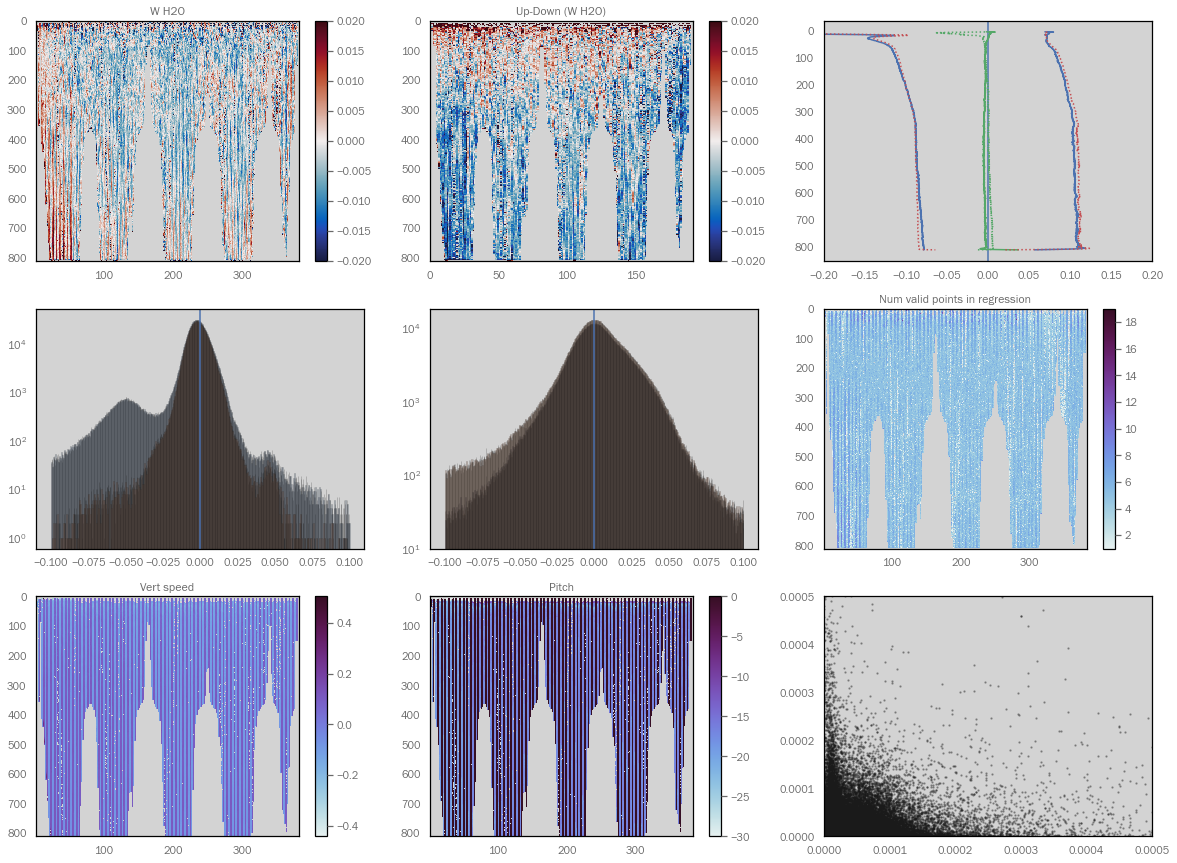

In [35]:
def verify(flight):
    plt.figure(figsize=(20,15))

    mask = flight._valid # & (np.sign(flight.dZdt) == -1)
    
    plt.subplot(331)
    V,XI,YI = sx.grid2d(
        data.data.profileNum[mask].values,
        data.data.LEGATO_PRESSURE[mask].values, 
        flight.w_H2O[mask], 
        xi=xaxis, yi=yaxis, fn='mean')
    DZ,XI,YI = sx.grid2d(
        data.data.profileNum[mask].values,
        data.data.LEGATO_PRESSURE[mask].values, 
        flight.dZdt[mask], 
        xi=xaxis, yi=yaxis, fn='mean')
    SV,XI,YI = sx.grid2d(
        data.data.profileNum[mask].values,
        data.data.LEGATO_PRESSURE[mask].values, 
        flight.speed_vert[mask], 
        xi=xaxis, yi=yaxis, fn='mean')
    
    plt.pcolormesh(XI,YI,V,cmap=cmo.balance,shading='auto')
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.clim([-0.02,0.02])
    plt.title('W H2O')
    
    plt.subplot(332)
    if np.remainder(np.shape(V)[1],2) == 1:
        plt.pcolormesh(XI[:,:-1:2]/2,YI[:,:-1:2],V[:,:-1:2]-V[:,1::2],cmap=cmo.balance,shading='auto')
    else:
        plt.pcolormesh(XI[:,::2]/2,YI[:,::2],V[:,::2]-V[:,1::2],cmap=cmo.balance,shading='auto')
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.clim([-0.02,0.02])
    plt.title('Up-Down (W H2O)')
    
    plt.subplot(333)
    plt.axvline(0)
    plt.plot(np.nanmean(V[:,::2],axis=1),yaxis,'-g')
    plt.plot(np.nanmean(V[:,1::2],axis=1),yaxis,':g')
    plt.plot(np.nanmean(DZ[:,::2],axis=1),yaxis,'-b')
    plt.plot(np.nanmean(DZ[:,1::2],axis=1),yaxis,'-b')
    plt.plot(np.nanmean(SV[:,::2],axis=1),yaxis,':r')
    plt.plot(np.nanmean(SV[:,1::2],axis=1),yaxis,':r')
    plt.xlim([-0.2, 0.2])
    plt.gca().invert_yaxis()
    
    plt.subplot(334)
    _ = plt.hist(flight.w_H2O.flatten(), np.linspace(-0.1,0.1,1000),alpha=0.2)
    _ = plt.hist(flight.w_H2O[mask].flatten(), np.linspace(-0.1,0.1,1000),alpha=0.2)
    plt.axvline(0)
    plt.yscale('log')
    
    
    plt.subplot(335)
    _ = plt.hist(flight.speed[mask] - flight.speed_through_water[mask], np.linspace(-0.1,0.1,1000),alpha=0.2)
    _ = plt.hist(flight.speed - flight.speed_through_water, np.linspace(-0.1,0.1,1000),alpha=0.2)
    plt.axvline(0)
    plt.yscale('log')
    
    plt.subplot(336)
    V,XI,YI = sx.grid2d(
        data.data.profileNum[mask].values,
        data.data.LEGATO_PRESSURE[mask].values, 
        flight._valid[mask], 
        xi=xaxis, yi=yaxis, fn='sum')
    plt.pcolormesh(XI,YI,V,cmap=cmo.dense,shading='auto')
    plt.colorbar()
    plt.gca().invert_yaxis()
    # plt.clim([-0.02,0.02])
    plt.title('Num valid points in regression')
    
    plt.subplot(337)
    V,XI,YI = sx.grid2d(
        data.data.profileNum[mask].values,
        data.data.LEGATO_PRESSURE[mask].values, 
        flight.dZdt[mask], 
        xi=xaxis, yi=yaxis, fn='mean')
    plt.pcolormesh(XI,YI,V,cmap=cmo.dense,shading='auto')
    plt.colorbar()
    plt.gca().invert_yaxis()
    # plt.clim([-0.02,0.02])
    plt.title('Vert speed')
    
    plt.subplot(338)
    V,XI,YI = sx.grid2d(
        data.data.profileNum[mask].values,
        data.data.LEGATO_PRESSURE[mask].values, 
        np.rad2deg(flight.pitch[mask]), 
        xi=xaxis, yi=yaxis, fn='mean')
    plt.pcolormesh(XI,YI,V,cmap=cmo.dense,shading='auto')
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.clim([-30,0])
    plt.title('Pitch')
    
    
    plt.subplot(339)
    V,XI,YI = sx.grid2d(
        data.data.profileNum.values,
        data.data.LEGATO_PRESSURE.values, 
        flight.w_H2O, 
        xi=1, yi=np.arange(0,1000,5), fn='mean')
    SA,_,_ = sx.grid2d(
        data.data.profileNum.values,
        data.data.LEGATO_PRESSURE.values, 
        data.data.sa, 
        xi=1, yi=np.arange(-2.5,1002.5,5), fn='mean')
    CT,_,YI2 =sx.grid2d(
        data.data.profileNum.values,
        data.data.LEGATO_PRESSURE.values, 
        data.data.ct, 
        xi=1, yi=np.arange(-2.5,1002.5,5), fn='mean')
    N2,_ = gsw.Nsquared(SA,CT,YI2)
    
    plt.scatter(N2.flatten(),V.flatten()**2,2,'k',alpha=0.3)
    plt.xlim([0,5e-4])
    plt.ylim([0,5e-4])
    
verify(flight)

## 5.2. Calculate dive-averaged current

No final GPS for dive 191.0


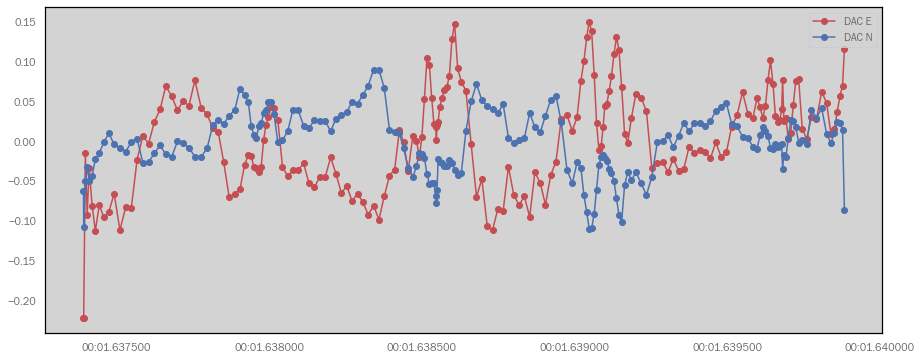

In [36]:
def _getDAC(data):
    ## Calculate full x-y dead reckoning during each dive
    def reset_transport_at_GPS(arr):
        ffill = lambda arr: pd.DataFrame(arr).fillna(method='ffill').values.flatten()
        ref = np.zeros(np.shape(arr)) * np.NaN
        ref[_gps] = arr[_gps]
        return (arr - ffill(ref))
    
    _gps = (data.data.DeadReckoning.values < 1) & (data.data.NAV_RESOURCE.values == 116)
    
    t = data.data.date_float.values * 1e-9
    heading = interp(ADCP['time'].values.astype('float'), ADCP['Heading'].values, data.data.date_float.values)
    # heading = (data.data['Heading'] + data.data['Declination']).interpolate('linear')
    vg_e = np.nan_to_num(data.data['speed_horz'] *np.sin( heading * np.pi/180 ))
    vg_n = np.nan_to_num(data.data['speed_horz'] *np.cos( heading * np.pi/180 ))
    
    data.data['speed_e'] = vg_e
    data.data['speed_n'] = vg_n
    
    de = np.cumsum(np.append(0, vg_e[1:] * np.diff(t)))
    dn = np.cumsum(np.append(0, vg_n[1:] * np.diff(t)))

    de = reset_transport_at_GPS(de)
    dn = reset_transport_at_GPS(dn)

    ## Calculate on per dive basis
    dnum = np.unique(data.data.diveNum.values)
    sidx = np.zeros(np.shape(dnum))*np.NaN
    didx = np.zeros(np.shape(dnum))*np.NaN
    
    for idx,dx in enumerate(dnum):
        try:
            sidx[idx] = np.flatnonzero((data.data.diveNum.values == dx) & _gps)[0]
            didx[idx] = np.flatnonzero((data.data.diveNum.values == dx) & _gps)[-1]
        except:
            continue
                        
    _gd = np.isfinite(sidx+didx+dnum)
    dnum = dnum[_gd]
    sidx = sidx[_gd]
    didx = didx[_gd]
    
    sidx = sidx.astype(int)
    didx = didx.astype(int)
   
    surf_lat = data.data.latitude.values[sidx]
    surf_lon = data.data.longitude[sidx]
    surf_time = t[sidx]

    dive_lat = data.data.latitude[didx]
    dive_lon = data.data.longitude[didx]
    dive_time = t[didx]

    dr_e = np.zeros(np.shape(dnum)) * np.NaN
    dr_n = np.zeros(np.shape(dnum)) * np.NaN
    gps_e = np.zeros(np.shape(dnum)) * np.NaN
    gps_n = np.zeros(np.shape(dnum)) * np.NaN
    dt = np.zeros(np.shape(dnum)) * np.NaN
    meant = np.zeros(np.shape(dnum)) * np.NaN

    lon2m = lambda x,y : gsw.distance([x,x+1],[y,y])
    lat2m = lambda x,y : gsw.distance([x,x],[y,y+1])
    
    for idx,dx in enumerate(dnum):
        try:
            dr_e[idx] = de[ sidx[idx+1]-1 ]
            dr_n[idx] = dn[ sidx[idx+1]-1 ]
            gps_e[idx] = (surf_lon[idx+1] - dive_lon[idx]) * lon2m(dive_lon[idx],dive_lat[idx])
            gps_n[idx] = (surf_lat[idx+1] - dive_lat[idx]) * lat2m(dive_lon[idx],dive_lat[idx])
            dt[idx] = surf_time[idx+1] - dive_time[idx]
            meant[idx] = (surf_time[idx+1] + dive_time[idx])/2
        except:
            print('No final GPS for dive '+str(dx))

    dac_e = (gps_e-dr_e)/dt
    dac_n = (gps_n-dr_n)/dt
    
    plt.figure(figsize=(15,6))
    plt.plot(pd.to_datetime(meant),dac_e,'o-r')
    plt.plot(pd.to_datetime(meant),dac_n,'o-b')
    plt.legend(('DAC E','DAC N'))

    data.data['DAC_E'] = interp(meant, (gps_e-dr_e)/dt, t)
    data.data['DAC_N'] = interp(meant, (gps_n-dr_n)/dt, t)
    
    data.data['DAC_E'] = data.data['DAC_E'].fillna(method='bfill').fillna(method='ffill')
    data.data['DAC_N'] = data.data['DAC_N'].fillna(method='bfill').fillna(method='ffill')
    
_getDAC(data)

Text(0.5, 1.0, 'North')

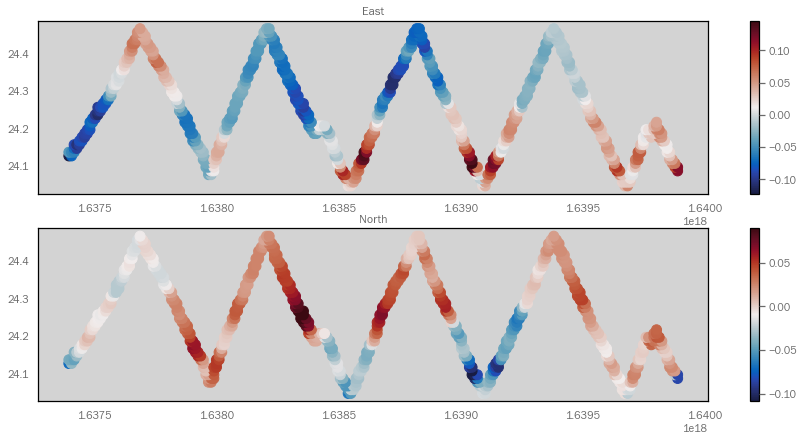

In [37]:
plt.figure(figsize=(15,7))

E,X,Y = sx.grid2d(data.data.Timestamp.values.astype('float'), data.data.latitude, data.data.DAC_E, xi= 10**9 * 60 * 60 * 3, yi=0.01)

N,X,Y = sx.grid2d(data.data.Timestamp.values.astype('float'), data.data.latitude, data.data.DAC_N, xi= 10**9 * 60 * 60 * 3, yi=0.01)

plt.subplot(211)
plt.scatter(X, Y, 100, E, cmap=cmo.balance)
plt.colorbar()
plt.title('East')

plt.subplot(212)
plt.scatter(X, Y, 100, N, cmap=cmo.balance)
plt.colorbar()
plt.title('North')

## 5.3. Get surface drift

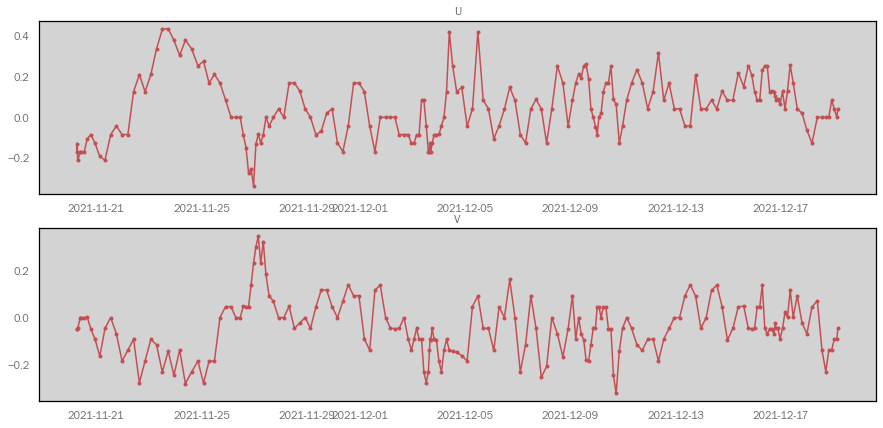

In [38]:
def getSurfaceDrift():
    _gps = (data.data.DeadReckoning.values < 1) & (data.data.NAV_RESOURCE.values == 116)
    
    lon2m = lambda x,y : gsw.distance([x,x+1],[y,y])
    lat2m = lambda x,y : gsw.distance([x,x],[y,y+1])
    
    dnum = data.data.diveNum.values[_gps]
    
    lons = data.data.longitude.values[_gps]
    lats = data.data.latitude.values[_gps]
    
    dlons = np.gradient(lons)
    dlats = np.gradient(lats)
        
    for idx in range(len(lons)):
        dlons[idx] = dlons[idx] * lon2m(lons[idx],lats[idx])
        dlats[idx] = dlats[idx] * lat2m(lons[idx],lats[idx])
    
    times = data.data.Timestamp.values.astype('float')[_gps] / 10**9
    dtimes = np.gradient(times)
    
    dE = np.full(int(np.nanmax(data.data.diveNum)), np.NaN)
    dN = np.full(int(np.nanmax(data.data.diveNum)), np.NaN)
    dT = np.full(int(np.nanmax(data.data.diveNum)), np.NaN)
    
    for idx in range(len(dE)):
        _gd = (dtimes < 21) & (dnum == idx+1)
        dE[idx] = np.nanmedian(dlons[_gd]/dtimes[_gd])
        dN[idx] = np.nanmedian(dlats[_gd]/dtimes[_gd])
        dT[idx] = np.nanmean(times[_gd])
    
    dT = dT * 10**9
    
    plt.figure(figsize=(15,7))
    plt.subplot(211)
    plt.plot(pd.to_datetime(dT),dE,'.-r')
    plt.title('U')
    plt.subplot(212)
    plt.plot(pd.to_datetime(dT),dN,'.-r')
    plt.title('V')
    
    return dE,dN,dT
    
    
dE,dN,dT = getSurfaceDrift()

## 5.4. Get bottom track data

In [39]:
def _process(ADCP):
    def sin(x):
        return np.sin(np.deg2rad(x))
    def cos(x):
        return np.cos(np.deg2rad(x))
    # BT gives us speed of the glider
    # If we subtract BT velocity from XYZ
    # then we get speed of water
    BT = xr.open_mfdataset(adcp_path,group='Data/AverageBT')

    thresh = 12

    ind = (BT['VelocityBeam1'] > -2) & (BT['VelocityBeam2'] > -2) & (BT['VelocityBeam4'] > -2)
    ind2 = (BT['FOMBeam1'] < thresh) & (BT['FOMBeam2'] < thresh) & (BT['FOMBeam4'] < thresh)
    BT = BT.isel(time=ind & ind2)
    
    full_time = ADCP['time'].values.astype('float')
    BT_time = BT['time'].values.astype('float')
    matching = []
    for idx in tqdm(range(len(BT_time))):
        matching.append( np.argmin( np.abs(BT_time[idx]-full_time) ) )
        
    ADCP_profile = ADCP['profileNum'].values.copy()
    ADCP_depth = ADCP['Pressure'].values.copy()
    for idx in range( np.nanmax(ADCP_profile).astype(int) ):
        _gd = (ADCP_profile == idx)
        if np.count_nonzero(_gd) == 0:
            print('Profile '+str(idx)+' was empy')
        else:
            ADCP_depth[_gd] = np.nanmax(ADCP_depth[_gd])
    ADCP_depth = ADCP_depth[matching]
    
    
    _gd = (np.abs(ADCP_depth-BT['Pressure']).values < 15)
    BT = BT.isel(time=_gd)
    full_time = ADCP['time'].values.astype('float')
    BT_time = BT['time'].values.astype('float')
    matching = []
    for idx in tqdm(range(len(BT_time))):
        matching.append( np.argmin( np.abs(BT_time[idx]-full_time) ) )
    
    C_old = BT['SpeedOfSound'].values
    C_new = ADCP['SpeedOfSound'].isel(time=matching).values
    
    a = 47.5 # Beam 1 and 3 angle from Z
    b = 25 # Beam 2 and 4 angle from Z
    xyz2beam_fore = np.array([
        [sin(a),0,cos(a)],
        [0,-sin(b),cos(b)],
        [0,sin(b),cos(b)]
    ])
    beam2xyz_fore = np.linalg.inv(xyz2beam_fore)
    
    BT_X4, BT_Y4, BT_Z4 = beam2xyz_fore @ np.array([
        BT['VelocityBeam1'] * (C_new/C_old),
        BT['VelocityBeam2'] * (C_new/C_old),
        BT['VelocityBeam4'] * (C_new/C_old),
        ])

    def M_xyz2enu(heading,pitch,roll):
        hh = np.pi*(heading-90)/180
        pp = np.pi*pitch/180
        rr = np.pi*roll/180

        _H = np.array([
            [np.cos(hh),np.sin(hh),0], 
            [-np.sin(hh),np.cos(hh),0], 
            [0,0,1]
        ])
        _P = np.array([
            [np.cos(pp), 0, -np.sin(pp)] ,
            [0, 1, 0] , 
            [ np.sin(pp), 0, np.cos(pp)]
        ])
        _R = np.array([
            [1, 0, 0] ,
            [0, np.cos(rr), -np.sin(rr)] , 
            [0, np.sin(rr), np.cos(rr)]
        ])

        _M = _H@_P@_R
        return _M

    H = BT['Heading'].values
    P = BT['Pitch'].values
    R = BT['Roll'].values

    BT_E = np.full_like(H,np.NaN)
    BT_N = np.full_like(H,np.NaN)
    BT_U = np.full_like(H,np.NaN)

    if top_mounted:
        direction = 1
    else:
        direction = -1

    n = len(BT_X4)
    for i in tqdm(range(n)):
        BT_E[i], BT_N[i], BT_U[i] = M_xyz2enu(H[i],P[i],R[i]) @ [BT_X4[i], BT_Y4[i]*direction, BT_Z4[i]*direction]   

    bt_e = np.full_like(full_time,np.NaN)
    bt_e[matching] = BT_E
    bt_n = np.full_like(full_time,np.NaN)
    bt_n[matching] = BT_N
    bt_u = np.full_like(full_time,np.NaN)
    bt_u[matching] = BT_U

    ADCP['BT_E'] = ('time', bt_e)
    ADCP['BT_N'] = ('time', bt_n)
    ADCP['BT_U'] = ('time', bt_u)
    
    return ADCP
    
ADCP = _process(ADCP)

100%|█████████████████████████████████████| 2042/2042 [00:05<00:00, 369.21it/s]


Profile 0 was empy
Profile 2 was empy


100%|███████████████████████████████████| 1124/1124 [00:00<00:00, 28843.06it/s]


## 5.5. Reference ADCP data

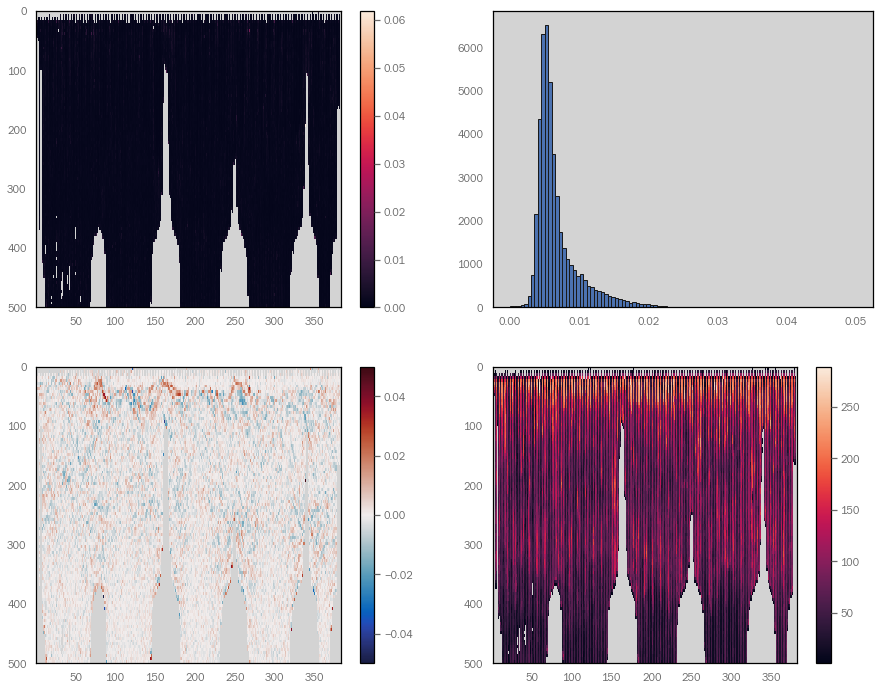

In [40]:
def verify():
    x = np.arange(0,np.shape(ADCP.Sh_E.values)[0],1)

    SHEm,XI,YI = sx.grid2d(
        np.tile(ADCP.profileNum.values, (len(ADCP.gridded_bin), 1)).T[x,:].flatten(),
        ADCP.bin_depth.values[x,:].flatten(), 
        ADCP.Sh_E.values[x,:].flatten(), 
        xi=1, yi=5, fn='mean')
    SHEs,XI,YI = sx.grid2d(
        np.tile(ADCP.profileNum.values, (len(ADCP.gridded_bin), 1)).T[x,:].flatten(),
        ADCP.bin_depth.values[x,:].flatten(), 
        ADCP.Sh_E.values[x,:].flatten(), 
        xi=1, yi=5, fn='std')
    SHEn,XI,YI = sx.grid2d(
        np.tile(ADCP.profileNum.values, (len(ADCP.gridded_bin), 1)).T[x,:].flatten(),
        ADCP.bin_depth.values[x,:].flatten(), 
        ADCP.Sh_E.values[x,:].flatten(), 
        xi=1, yi=5, fn='count')

    plt.figure(figsize=(15,12))

    plt.subplot(221)
    plt.pcolormesh(XI,YI,SHEs/np.sqrt(SHEn))
    plt.colorbar()
    # plt.clim([0,300])
    plt.ylim([0,500])
    plt.gca().invert_yaxis()

    plt.subplot(223)
    plt.pcolormesh(XI,YI,SHEm,cmap=cmo.balance)
    plt.colorbar()
    plt.ylim([0,500])
    plt.clim([-0.05,0.05])
    plt.gca().invert_yaxis()

    plt.subplot(224)
    plt.pcolormesh(XI,YI,SHEn)
    plt.colorbar()
    plt.ylim([0,500])
    # plt.clim([0,0.01])
    plt.gca().invert_yaxis()

    plt.subplot(222)
    _ = plt.hist(SHEs.flatten(), np.linspace(0,0.05,100))
    
verify()

C:\Users\bastien\AppData\Local\Temp\ipykernel_14252\3318242820.py:62: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(taxis,yaxis,V,cmap=cmo.balance,shading='auto')
D:\miniconda3\envs\py3.10\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\bastien\AppData\Local\Temp\ipykernel_14252\3318242820.py:62: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(taxis,yaxis,V,cmap=cmo.balance,shading='auto')
D:\miniconda3\envs\py3.10\lib\site-packages

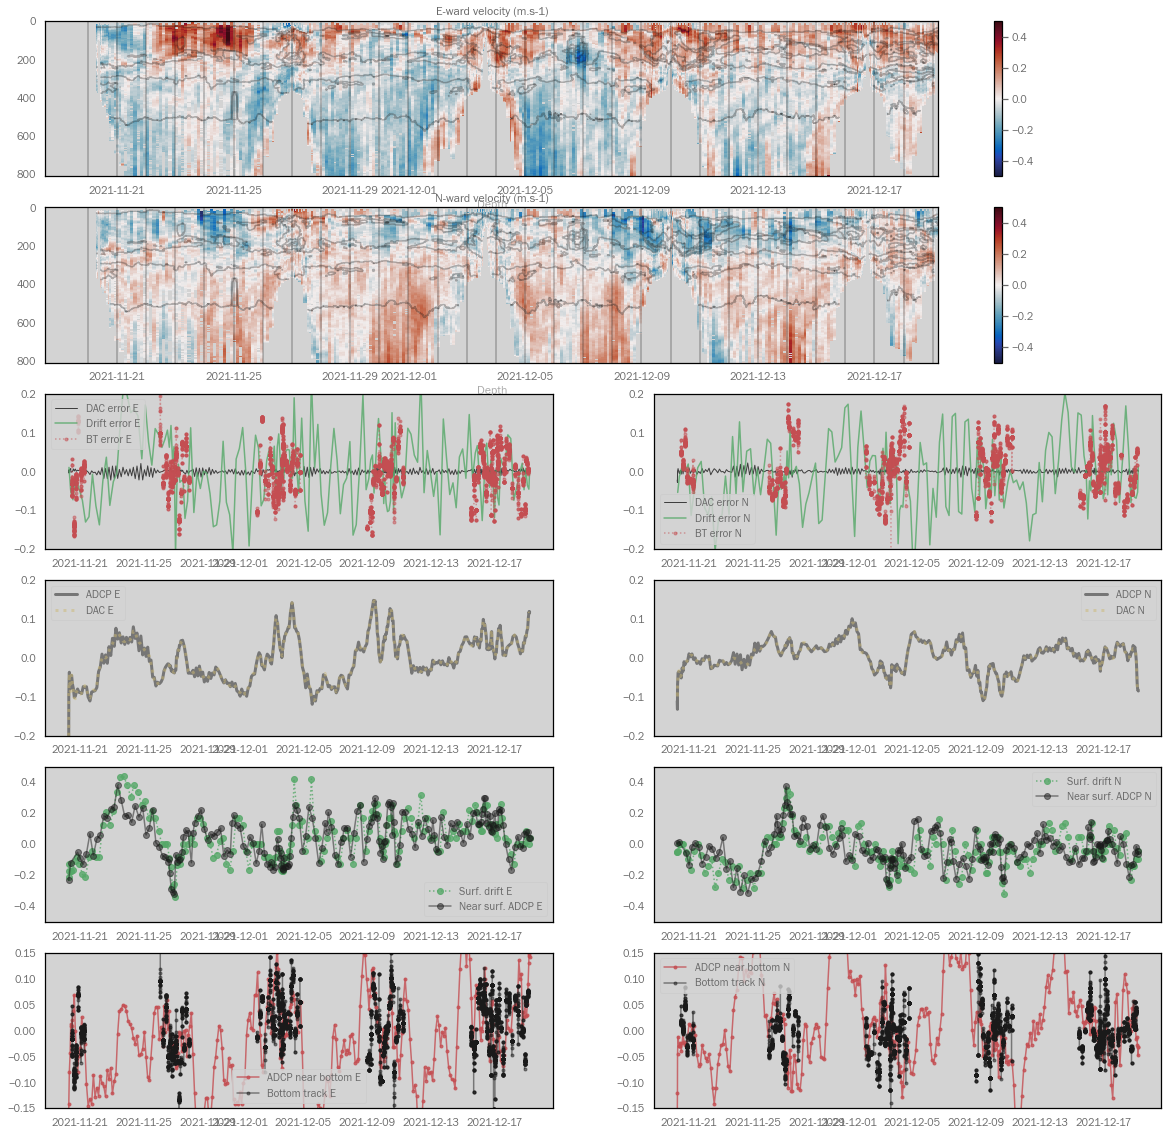

In [41]:
def _verify():
    var = ['E','N']
    
    plt.figure(figsize=(20,20))
    
    days = np.unique(data.data.Timestamp.round('D'))
    for pstep in range(len(var)):
        
        letter = var[pstep]
        # Grid shear to average out sensor + zooplankton noise
        Sh,XI,YI = sx.grid2d(
            np.tile(ADCP.profileNum.values, (len(ADCP.gridded_bin), 1)).T.flatten(),
            ADCP.bin_depth.values.flatten(), 
            ADCP['Sh_'+letter].values.flatten(), 
            xi=xaxis, yi=yaxis, fn='mean')

        # Integrate shear vertically
        _bd = ~np.isfinite(Sh) # Preserve what are originally NaN values to recover later as need conversion to 0 for cumsum-
        Sh = np.nan_to_num(Sh) # Replace NaNs with 0 for cumsum
        V = np.cumsum(Sh,axis=0)*y_res # Cumulative sum of shear to recover velocity profile
        V[_bd] = np.NaN # Return NaNs to their rightful place.
        V = V - np.tile(np.nanmean(V, axis=0), (np.shape(V)[0],1)) # Make mean of baroclinic profiles equal to 0

        # Grid DAC
        DAC,XI,YI = sx.grid2d(
            data.data.profileNum.values,
            data.data.LEGATO_PRESSURE.values, 
            data.data['DAC_'+letter].values, 
            xi=xaxis, yi=yaxis, fn='mean')

        # Grid vertical speed
        dPdz,XI,YI = sx.grid2d(
            data.data.profileNum.values,
            data.data.LEGATO_PRESSURE.values, 
            data.data['speed_vert'].values, 
            xi=xaxis, yi=yaxis, fn='mean')

        # Grid salinity
        SA,XI,YI = sx.grid2d(
            data.data.profileNum.values,
            data.data.LEGATO_PRESSURE.values, 
            data.data.sa.values, 
            xi=xaxis, yi=yaxis, fn='median')

        # Seconds spent in each depth bin, to weight referencing
        SpB = y_res / dPdz
        SpB[np.isinf(SpB)] = 0
        strictness = 1
        SpB_std = np.nanstd(SpB.flatten())
        SpB[ np.abs(SpB) > (strictness*SpB_std) ] = strictness*SpB_std

        # Baroclinic velocity, weighted by depth residence time, should be equal to DAC
        # So the reference to add to a baroclinic profile of mean = 0 is the DAC - the weighted baroclinic velocity.    
        Ref = np.nanmean(DAC, axis=0)  -  np.nansum(V*SpB, axis=0)/np.nansum(SpB, axis=0)

        # Now we reference the velocity
        V = V +  np.tile(Ref, (np.shape(V)[0],1))
        out['ADCP_'+letter] = V

        ## PLOT 1
        plt.subplot(6,1, pstep+1)
        plt.pcolormesh(taxis,yaxis,V,cmap=cmo.balance,shading='auto')
        plt.clim(np.array([-1,1])*0.5)
        plt.colorbar()
        [plt.axvline(x, color='k', alpha=0.3) for x in days]
        plt.contour(taxis,yaxis,SA,np.linspace(35.5,38.5,6),colors='k',alpha=0.3)
        plt.gca().invert_yaxis()
        plt.xlabel('Yo number')
        plt.xlabel('Depth')
        plt.title(letter+'-ward velocity (m.s-1)')
        
        ## PLOT 3
        plt.subplot(6,2, pstep+7)
        plt.plot(taxis,np.nanmean(V, axis=0),'-k',alpha=0.5, linewidth=3)
        plt.plot(taxis,np.nanmean(DAC, axis=0),':y',alpha=0.5, linewidth=3)
        plt.legend(('ADCP '+letter,'DAC '+letter))
        plt.ylim([-0.2,0.2])
        
        ## PLOT 4
        plt.subplot(6,2, pstep+9)
        max_depth = 26
        _gd = np.isfinite(dN+dE)
        if pstep==0:
            plt.plot(pd.to_datetime(dT[_gd]),dE[_gd],':og', alpha=0.8)
        else:
            plt.plot(pd.to_datetime(dT[_gd]),dN[_gd],':og', alpha=0.8)   
        V_surf = np.nanmean(V[:max_depth,:], axis=0)
        plt.plot(taxis[np.isfinite(V_surf)],V_surf[np.isfinite(V_surf)],'-ok',alpha=0.5)
        plt.legend(('Surf. drift '+letter,'Near surf. ADCP '+letter))
        plt.ylim([-0.5,0.5])
    
        ## PLOT 5
        plt.subplot(6,2, pstep+11)
        
        indices = np.flip(np.cumsum(np.flip(np.full_like(V,1)*np.isfinite(V),axis=0),axis=0),axis=0)
        indices[indices > 10] = np.NaN
        indices[np.isfinite(indices)] = 1
        bottom_V = np.nanmean(V*indices, axis=0)   
        plt.plot(taxis,RunningMean(bottom_V,1),'-r',marker='.',alpha=0.8)
        
        ind = np.arange(len(ADCP['time'])) #np.isfinite(ADCP['BT_'+letter].values)
        bt_t = ADCP['time'].isel(time=ind).values
        bt = (ADCP[letter]-ADCP['BT_'+letter]).isel(time=ind).mean('gridded_bin').values
        bt_std = (ADCP[letter]-ADCP['BT_'+letter]).isel(time=ind).std('gridded_bin').values
    
        bt_smooth = 30
        plt.plot( bt_t , RunningMean(bt,bt_smooth), '-k', marker='.', alpha=0.5)
        plt.ylim([-0.15,0.15])
        plt.legend(('ADCP near bottom '+letter,'Bottom track '+letter))
        
        
        ## PLOT 2
        plt.subplot(6,2, pstep+5)
        plt.plot(taxis,np.nanmean(V, axis=0) - np.nanmean(DAC, axis=0),'-k',alpha=0.8, linewidth=1)
        
        if pstep==0:
            plt.plot(pd.to_datetime(dT[_gd]),dE[_gd] - interp(taxis[np.isfinite(V_surf)].values.astype('float'),V_surf[np.isfinite(V_surf)],dT[_gd]) ,'-g', alpha=0.8)
        else:
            plt.plot(pd.to_datetime(dT[_gd]),dN[_gd] - interp(taxis[np.isfinite(V_surf)].values.astype('float'),V_surf[np.isfinite(V_surf)],dT[_gd]),'-g', alpha=0.8)   
        
        plt.plot( bt_t , RunningMean(bt,bt_smooth) - interp(taxis.values.astype('float'),RunningMean(bottom_V,1) , bt_t.astype('float')), ':r', marker='.', alpha=0.5)
        
        plt.legend(('DAC error '+letter,'Drift error '+letter,'BT error '+letter))
        plt.ylim([-0.2,0.2])
        
        
    plt.savefig(filename[:filename.rfind('/')+1]+'currents.png', bbox_inches='tight')
    
_verify()

# VI. Grid and plot data

In [42]:
def _grid_glider_data(data): 
    exclude_from_grid = ['AD2CP_ALT', 'AD2CP_HEADING', 'AD2CP_PITCH', 'AD2CP_PRESSURE',
    'AD2CP_ROLL', 'AROD_FT_DO', 'AROD_FT_TEMP', 'Altitude', 'AngCmd',
    'AngPos', 'BallastCmd', 'BallastPos', 'DeadReckoning', 'Declination',
    'Depth', 'DesiredH','LinCmd', 'LinPos','NAV_DEPTH', 'NAV_LATITUDE', 'NAV_LONGITUDE',
    'NAV_RESOURCE', 'NavState', 'Pa', 'Pitch', 'Roll', 'Heading', 'SecurityLevel', 'Temperature',
    'Timestamp', 'Unnamed: 22', 'Unnamed: 28', 'Voltage', 'missionNum','Lat','Lon']

    variables = data.columns
    variables = [x for x in variables if x not in exclude_from_grid]
    grid = lambda name : sx.grid2d(data.profileNum.values, data.LEGATO_PRESSURE.values, data[name].values, xi=xaxis, yi=yaxis, fn='mean')[0]

    for varname in tqdm(variables):
        try:
            out[varname] = grid(varname)
        except:
            print('Variable "'+varname+'" failed to grid.')
    return out

    for varname in out.keys():
        try:
            plt.close('all')
            plt.figure(figsize=(14,5))
            plt.pcolormesh(taxis,yaxis,out[varname],cmap=cmo.haline)
            plt.colorbar()
            plt.gca().invert_yaxis()
            plt.savefig(filename[:filename.rfind('/')+1]+varname+'.png', bbox_inches='tight')
            plt.close('all')
        except:
            print('Variable "'+varname+'" failed to plot.')
        

In [43]:
ADCP_pnum = np.tile(ADCP.profileNum, (len(ADCP.gridded_bin),1)).T
out['Sh_E'] = sx.grid2d(ADCP_pnum.flatten(), ADCP.bin_depth.values.flatten(), ADCP.Sh_E.values.flatten(), xi=xaxis, yi=yaxis, fn='mean')[0]
out['Sh_N'] = sx.grid2d(ADCP_pnum.flatten(), ADCP.bin_depth.values.flatten(), ADCP.Sh_N.values.flatten(), xi=xaxis, yi=yaxis, fn='mean')[0]
out['Sh_U'] = sx.grid2d(ADCP_pnum.flatten(), ADCP.bin_depth.values.flatten(), ADCP.Sh_U.values.flatten(), xi=xaxis, yi=yaxis, fn='mean')[0]
out['Heading'] = sx.grid2d(ADCP.profileNum.values, ADCP.Pressure.values, ADCP['Heading'].values, xi=xaxis, yi=yaxis, fn='mean')[0]
out['Pitch'] = sx.grid2d(ADCP.profileNum.values, ADCP.Pressure.values, ADCP['Pitch'].values, xi=xaxis, yi=yaxis, fn='mean')[0]
out['Roll'] = sx.grid2d(ADCP.profileNum.values, ADCP.Pressure.values, ADCP['Roll'].values, xi=xaxis, yi=yaxis, fn='mean')[0]

out = _grid_glider_data(data.data)

# out['ABS'] = sx.grid2d(ADCP_pnum.flatten(), ADCP.bin_depth.values.flatten(), 
#                           (ADCP.A1.values.flatten()+ADCP.A2.values.flatten()+ADCP.A3.values.flatten()+ADCP.A4.values.flatten())/4,
#                           xi=xaxis, yi=yaxis, fn='mean')[0]


100%|██████████████████████████████████████████| 40/40 [00:19<00:00,  2.06it/s]


100%|███████████████████████████████| 619604/619604 [00:17<00:00, 35148.40it/s]


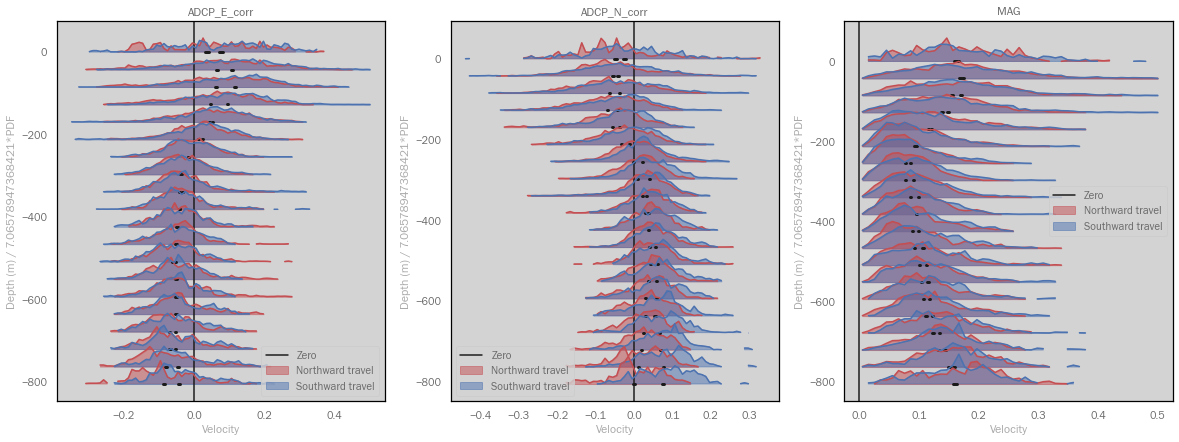

In [93]:
def get_bias(C):
    bias = yaxis*C/np.max(yaxis) 
    bias = bias-np.mean(bias)
    return np.tile(bias,[len(taxis),1]).T

def M_xyz2enu(heading,pitch,roll):
    hh = np.pi*(heading-90)/180
    pp = np.pi*pitch/180
    rr = np.pi*roll/180

    _H = np.array([
        [np.cos(hh),np.sin(hh),0], 
        [-np.sin(hh),np.cos(hh),0], 
        [0,0,1]
    ])
    _P = np.array([
        [np.cos(pp), 0, -np.sin(pp)] ,
        [0, 1, 0] , 
        [ np.sin(pp), 0, np.cos(pp)]
    ])
    _R = np.array([
        [1, 0, 0] ,
        [0, np.cos(rr), -np.sin(rr)] , 
        [0, np.sin(rr), np.cos(rr)]
    ])

    _M = _H@_P@_R
    return _M

X_bias = get_bias(0.12)
Y_bias = get_bias(0)

if top_mounted:
    direction = 1
else:
    direction = -1

# E = ADCP['X'].values.copy()
# N = ADCP['Y'].values.copy()*direction
# U = ADCP['Z'].values.copy()*direction

r,c = np.shape(X_bias)

X = X_bias.flatten()
Y = Y_bias.flatten()
H = out['Heading'].flatten()
P = out['Pitch'].flatten()
R = out['Roll'].flatten()

E_bias = np.full(len(X),np.NaN)
N_bias = np.full(len(X),np.NaN)
U_bias = np.full(len(X),np.NaN)

for i in tqdm(range(len(X))):
    E_bias[i], N_bias[i], _ = M_xyz2enu(H[i],P[i],R[i]) @ [X[i], Y[i], 0]

E_bias = np.reshape(E_bias, (r,c))
N_bias = np.reshape(N_bias, (r,c))

out['ADCP_E_corr'] = out['ADCP_E'] + E_bias
out['ADCP_N_corr'] = out['ADCP_N'] + N_bias
verify_depth_bias()

  9%|███▊                                      | 9/100 [00:00<00:09,  9.73it/s]


Optimization terminated successfully.
         Current function value: 0.180214
         Iterations: 9
         Function evaluations: 18
(array([0.000435]), 0.18021397877075795, 9, 18, 0)


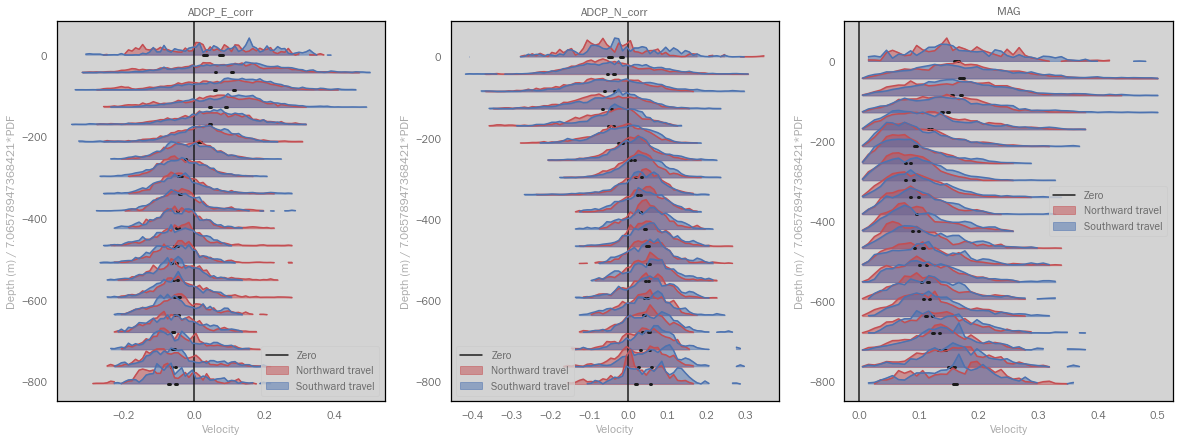

In [92]:
def get_bias(glider_speed, coeff):
    r,c = np.shape(glider_speed)
    bias = np.nancumsum(glider_speed,axis=0)
    bias[~np.isfinite(glider_speed)] = np.NaN
    bias = bias - np.tile(np.nanmean(bias, axis=0),[r,1])
    return bias*coeff

def score(E,N):
    rmsd_h = lambda x: np.sqrt(np.nanmean(x**2, axis=1))
    rmsd = lambda x: np.sqrt(np.nanmean(x**2))
    return rmsd((rmsd_h(E)+rmsd_h(N)))

def fn(coeff):
    return score(out['ADCP_E'] + get_bias(out['speed_e'], coeff),out['ADCP_N'] + get_bias(out['speed_n'], coeff))

from scipy.optimize import fmin
with tqdm(total=100) as pbar:
    def callbackF(Xi):
        pbar.update(1)
    R = fmin(fn, 0.0001, callback=callbackF, disp=True, full_output=True, maxiter=100, ftol=0.00001)
print(R)
coeff = R[0]
out['ADCP_E_corr'] = out['ADCP_E'] + get_bias(out['speed_e'], coeff)
out['ADCP_N_corr'] = out['ADCP_N'] + get_bias(out['speed_n'], coeff)
verify_depth_bias()

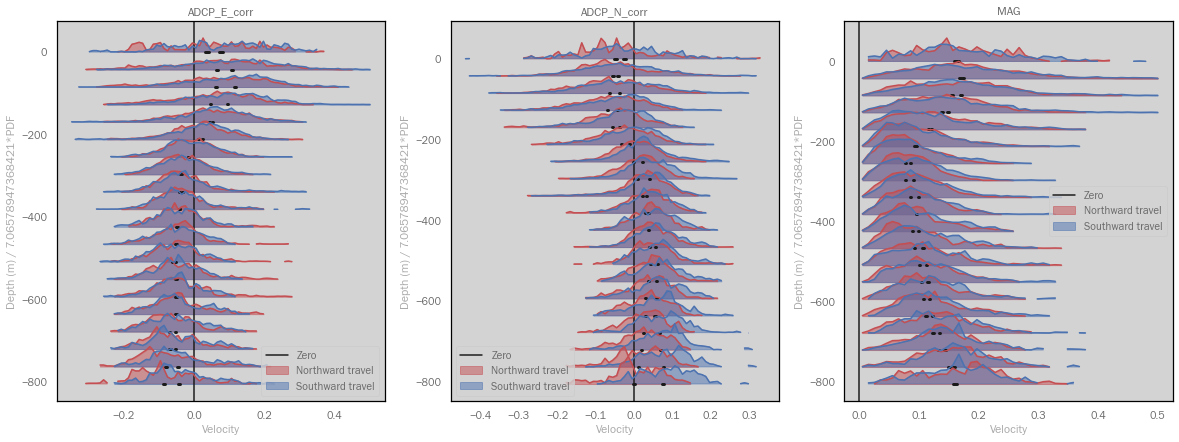

In [91]:
def verify_depth_bias():
    
    north = np.gradient(out['latitude'],axis=1) > 0
    south = np.gradient(out['latitude'],axis=1) < 0
    
    up = np.remainder(out['profileNum'],2) == 0
    down = np.remainder(out['profileNum'],2) == 1
    
    
    depths = np.linspace(0,np.max(yaxis)-5,20)
    drange = np.mean(np.diff(depths))/2
    bins = np.linspace(-1,1,100) * 0.5
    
    variables = ['ADCP_E_corr','ADCP_N_corr']
    
    plt.figure(figsize=(20,7))
    
    SF = drange/3
    
    for idx,var in enumerate(variables):
        plt.subplot(1,3,idx+1)
        plt.axvline(0,color='k')

        for idx, d in enumerate(depths):
            depth = (np.abs(out['LEGATO_PRESSURE'] - d) < drange)
            
            Nvals = out[var][(north & depth)]
            Svals = out[var][(south & depth)]
            N,_ = np.histogram(Nvals,bins=bins,density=True)
            S,_ = np.histogram(Svals,bins=bins,density=True)

            Nm = np.nanmean(Nvals)
            Sm = np.nanmean(Svals)
            Ns = np.nanstd(Nvals)
            Ss = np.nanstd(Svals)
            Nn = np.count_nonzero(np.isfinite(Nvals))
            Sn = np.count_nonzero(np.isfinite(Svals))
            Nse = Ns / np.sqrt(Nn)
            Sse = Ss / np.sqrt(Sn)

            N[N==0] = np.NaN
            S[S==0] = np.NaN

            plt.fill_between(bins[1:],SF*N-float(d),-float(d),color='r',alpha=0.5)
            plt.fill_between(bins[1:],SF*S-float(d),-float(d),color='b',alpha=0.5)
            plt.plot(bins[1:],SF*N-float(d),'-r')
            plt.plot(bins[1:],SF*S-float(d),'-b')
        
            plt.plot([Nm-2*Nse,Nm+2*Nse],np.array([1,1])*-float(d),'-k',linewidth=3,alpha=1)
            plt.plot([Sm-2*Sse,Sm+2*Sse],np.array([1,1])*-float(d),'-k',linewidth=3,alpha=1)
            # plt.plot([Nm,Sm],np.array([1,1])*-float(d),'k',marker='.',linestyle='none')

        plt.ylabel('Depth (m) / '+str(SF)+'*PDF')
        plt.xlabel('Velocity')
        plt.legend(('Zero','Northward travel','Southward travel'))
        plt.title(var)
        
    plt.subplot(133)    
    plt.axvline(0,color='k')

    for idx, d in enumerate(depths):
        depth = (np.abs(out['LEGATO_PRESSURE'] - d) < drange)

        Nvals = np.sqrt(out['ADCP_E']**2 + out['ADCP_N']**2)[(north & depth)]
        Svals = np.sqrt(out['ADCP_E']**2 + out['ADCP_N']**2)[(south & depth)]
        N,_ = np.histogram(Nvals,bins=bins,density=True)
        S,_ = np.histogram(Svals,bins=bins,density=True)

        Nm = np.nanmean(Nvals)
        Sm = np.nanmean(Svals)
        Ns = np.nanstd(Nvals)
        Ss = np.nanstd(Svals)
        Nn = np.count_nonzero(np.isfinite(Nvals))
        Sn = np.count_nonzero(np.isfinite(Svals))
        Nse = Ns / np.sqrt(Nn)
        Sse = Ss / np.sqrt(Sn)

        N[N==0] = np.NaN
        S[S==0] = np.NaN

        plt.fill_between(bins[1:],SF*N-float(d),-float(d),color='r',alpha=0.5)
        plt.fill_between(bins[1:],SF*S-float(d),-float(d),color='b',alpha=0.5)
        plt.plot(bins[1:],SF*N-float(d),'-r')
        plt.plot(bins[1:],SF*S-float(d),'-b')
        
        plt.plot([Nm-2*Nse,Nm+2*Nse],np.array([1,1])*-float(d),'-k',linewidth=3,alpha=1)
        plt.plot([Sm-2*Sse,Sm+2*Sse],np.array([1,1])*-float(d),'-k',linewidth=3,alpha=1)
        # plt.plot([Nm,Sm],np.array([1,1])*-float(d),'k',marker='.',linestyle='none')

    plt.ylabel('Depth (m) / '+str(SF)+'*PDF')
    plt.xlabel('Velocity')
    plt.legend(('Zero','Northward travel','Southward travel'))
    plt.title('MAG')

    plt.savefig(filename[:filename.rfind('/')+1]+'ADCP_dsitribution.png', bbox_inches='tight')

    return None

verify_depth_bias()

In [47]:
def exportCSVfiles():
    for key in out:
        print(key)
        np.savetxt(filename[:filename.rfind('/')+1]+key+'.csv', out[key], delimiter=",") 
# exportCSVfiles()

In [48]:
options

{'correctRBRLag': False,
 'correctADCPHeading': True,
 'ADCP_discardFirstBin': True,
 'ADCP_correlationThreshold': 60,
 'ADCP_amplitudeThreshold': 75,
 'ADCP_velocityThreshold': 0.6,
 'correctXshear': False,
 'correctYshear': False,
 'correctZshear': False,
 'correctZZshear': False}

# END OF FILE